In [28]:
eda = input("Do you want to do EDA? (y/n)\n")

Do you want to do EDA? (y/n)
y


In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# importing baseline models
from sklearn import linear_model
from sklearn.naive_bayes import *
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import catboost
import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import StackingClassifier

In [81]:
# Code for calculating Normalized gini coefficient
# Taken from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert( len(actual) == len(pred) )  
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)  
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]  
    totalLosses = all[:,0].sum()  
    giniSum = all[:,0].cumsum().sum() / totalLosses  
  
    giniSum -= (len(actual) + 1) / 2  
    return giniSum / len(actual)  
  
def gini_normalized(a, p):  
    return gini(a, p) / gini(a, a)

# Impute Missing Values
def impute(df, cols, strat):
    if(strat=="constant"):
        x = input("Enter the string: ")
        imputer= Imputer(strategy=strat, fill_value=str(x))
    else:
        imputer = Imputer(strategy=strat)
    df_impute = df[cols]
    df[cols] = imputer.fit_transform(df_impute)
    return df

## Removing the outliers in the box plots
def remove_outliers(x,df,col):
    q1 = df[col].quantile(q = 0.25)
    q3 = df[col].quantile(q = 0.75)
    iqr = q3 - q1
    outlier_range = 1.5*iqr
    r_whisker = q3 + outlier_range
    l_whisker = q1 - outlier_range
    if (x > r_whisker):
        return q3
    elif (x < l_whisker):
        return q1
    else: 
        return x    
    
def check_missing_data(data):
    d = pd.DataFrame()
    for val in data.columns.values:
        count = data[data[val]==-1].shape[0]
        vals = pd.DataFrame({"Count":count,"%":(count/data[val].shape[0])*100}, index=[val])
        d = d.append(vals)
        #print("% data missing in {} =\t {},\t {:.4f}%".format(val,count,((count/data[val].shape[0])*100)))
    return d
        
def one_hot_encode(train, test, cat_cols):
    train = pd.get_dummies(train, columns=cat_cols)
    test = pd.get_dummies(test, columns=cat_cols)
    return train, test

def check_data(df):
    vals=df.isnull().sum()
    percent=(100*vals)/len(df)
    type_data=df.dtypes
    diff_vals = df.nunique()
    sk = df.skew()
    table = pd.concat([vals,percent,type_data,diff_vals,sk],axis=1)
    table = table.rename(columns={0:"missing", 1:"missing %", 2:"dtype", 3:"# unique", 4:"skew"})
    return table

def get_scoring_plots(train_pred, test_pred, train_Y, test_Y):
    f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
    train_cnf = confusion_matrix(train_Y, np.round(train_pred))
    val_cnf = confusion_matrix(test_Y, np.round(test_pred))

    train_cnf = train_cnf / train_cnf.sum(axis=1)[:, np.newaxis]
    val_cnf = val_cnf / val_cnf.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf, index=[0, 1], columns=[0, 1])
    val_df_cm = pd.DataFrame(val_cnf, index=[0, 1], columns=[0, 1])

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="inferno", ax=axes[0]).set_title("Train")
    sns.heatmap(val_df_cm, annot=True, fmt='.2f', cmap="inferno", ax=axes[1]).set_title("Validation")
    plt.show()

In [31]:
train = pd.read_csv("../input/porto-seguro-new/train.csv")
test = pd.read_csv("../input/porto-seguro-new/test.csv")

In [32]:
check_missing_data(train)

,Count,%
id,0,0.000000
target,0,0.000000
ps_ind_01,0,0.000000
ps_ind_02_cat,148,0.035522
ps_ind_03,0,0.000000
ps_ind_04_cat,55,0.013201
ps_ind_05_cat,4047,0.971324
ps_ind_06_bin,0,0.000000
ps_ind_07_bin,0,0.000000
ps_ind_08_bin,0,0.000000


# Getting to know the dataset

**Pre existing knowledge about data:**

1. target column in train dataset is the output.
2. There are no missing values in the data, they have been replaced by -1.
3. There are calculated features.

In [33]:
print(train.shape)
print(test.shape)

(416648, 59)
(178564, 58)


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416648 entries, 0 to 416647
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              416648 non-null  int64  
 1   target          416648 non-null  int64  
 2   ps_ind_01       416648 non-null  int64  
 3   ps_ind_02_cat   416648 non-null  int64  
 4   ps_ind_03       416648 non-null  int64  
 5   ps_ind_04_cat   416648 non-null  int64  
 6   ps_ind_05_cat   416648 non-null  int64  
 7   ps_ind_06_bin   416648 non-null  int64  
 8   ps_ind_07_bin   416648 non-null  int64  
 9   ps_ind_08_bin   416648 non-null  int64  
 10  ps_ind_09_bin   416648 non-null  int64  
 11  ps_ind_10_bin   416648 non-null  int64  
 12  ps_ind_11_bin   416648 non-null  int64  
 13  ps_ind_12_bin   416648 non-null  int64  
 14  ps_ind_13_bin   416648 non-null  int64  
 15  ps_ind_14       416648 non-null  int64  
 16  ps_ind_15       416648 non-null  int64  
 17  ps_ind_16_

In [35]:
check_data(train)

,missing,missing %,dtype,# unique,skew
id,0,0.0,int64,416648,-0.000372
target,0,0.0,int64,2,4.940782
ps_ind_01,0,0.0,int64,8,0.932070
ps_ind_02_cat,0,0.0,int64,5,1.974004
ps_ind_03,0,0.0,int64,12,0.463321
ps_ind_04_cat,0,0.0,int64,3,0.332916
ps_ind_05_cat,0,0.0,int64,8,3.235336
ps_ind_06_bin,0,0.0,int64,2,0.435081
ps_ind_07_bin,0,0.0,int64,2,1.112739
ps_ind_08_bin,0,0.0,int64,2,1.812115


In [36]:
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,4.166480e+05,416648.000000,416648.000000,416648.000000,416648.000000,416648.00000,416648.000000,416648.000000,416648.000000,416648.00000,...,416648.000000,416648.000000,416648.000000,416648.000000,416648.000000,416648.000000,416648.000000,416648.000000,416648.000000,416648.000000
mean,7.440545e+05,0.036532,1.902215,1.358638,4.427591,0.41711,0.405325,0.393716,0.256908,0.16428,...,5.440446,1.442443,2.871779,7.536038,0.122653,0.628199,0.554120,0.286561,0.349580,0.153285
std,4.293401e+05,0.187610,1.984801,0.665152,2.700164,0.49335,1.351530,0.488574,0.436928,0.37053,...,2.331708,1.203874,1.695352,2.746347,0.328039,0.483286,0.497063,0.452155,0.476838,0.360263
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.00000,-1.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.721285e+05,0.000000,0.000000,1.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.445190e+05,0.000000,1.000000,1.000000,4.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115724e+06,0.000000,3.000000,2.000000,6.000000,1.00000,0.000000,1.000000,1.000000,0.00000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.00000,6.000000,1.000000,1.000000,1.00000,...,19.000000,10.000000,13.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Separating useful columns**

In [37]:
train_target = train.target
test_id = test.id
train.drop(columns=['id','target'],inplace=True)
test.drop(columns=['id'],inplace=True)

**Target Analysis**

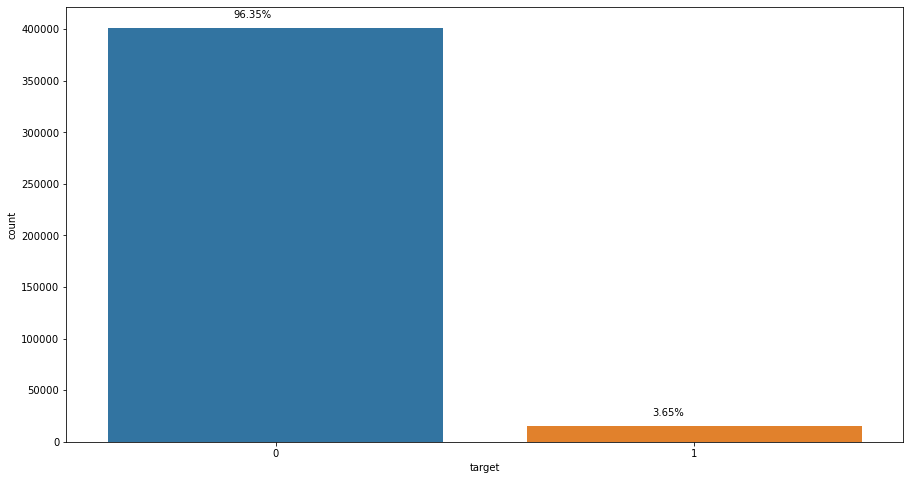

In [38]:
if(eda=='y'):
    plt.figure(figsize=(15,8))
    f = sns.countplot(train_target)
    for p in f.patches:
        f.annotate('{:.2f}%'.format(100*p.get_height()/len(train_target)), 
                    (p.get_x() + 0.3, p.get_height() + 10000))

**Analysing and separating the columns**

In [39]:
def analyse_columns(df):
    data = []
    for col in df.columns:
        if 'bin' in col:
            col_type = 'binary'
        elif 'cat' in col:
            col_type = 'nominal'
        elif df[col].dtype == np.float64:
            col_type = 'interval'
        elif df[col].dtype == np.int64:
            col_type = 'ordinal'
        
        data_type = df[col].dtype
        
        data_dict = {
            'column':col,
            'type':col_type,
            'data':data_type
        }
        
        data.append(data_dict)
    meta = pd.DataFrame(data,columns=['column', 'type', 'data'])
    return meta

,type,data
0,binary,17
1,interval,10
2,nominal,14
3,ordinal,16


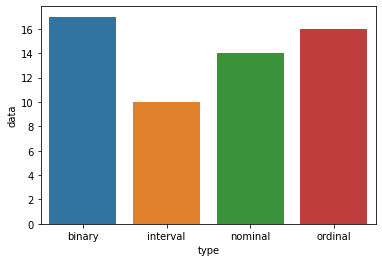

In [40]:
columns_analysis = analyse_columns(train)
data_type_count = columns_analysis.groupby(['type']).agg({'data': lambda x: x.count()}).reset_index()
display(data_type_count)
if(eda=='y'):
    sns.barplot(data=data_type_count, x='type', y='data')

**Separating the columns**

In [41]:
cat_cols = train.loc[:,train.columns.str.contains("cat")]
bin_cols = train.loc[:,train.columns.str.contains("bin")]
num_cols = train.drop(columns=['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat', 'ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin','ps_ind_16_bin','ps_ind_17_bin', 'ps_ind_18_bin','ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat','ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat','ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat','ps_calc_15_bin','ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin','ps_calc_20_bin'])

# Exploratory Data Analysis

**Binary columns**

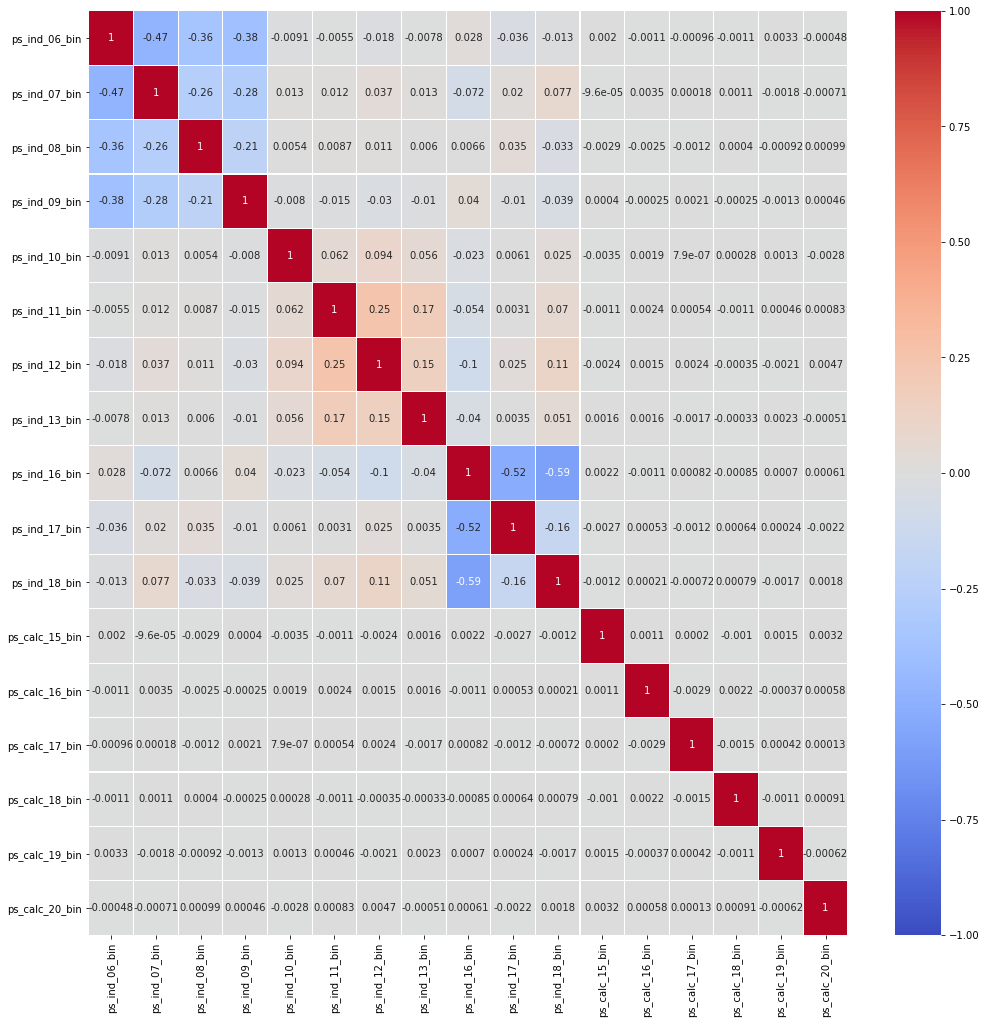

In [42]:
if(eda=='y'):
    plt.figure(figsize=(bin_cols.columns.nunique(),bin_cols.columns.nunique()))
    sns.heatmap(bin_cols.corr(), cmap="coolwarm",vmin=-1, annot=True, linewidths=0.1)

Hence, no serious correlation between the binary columns.

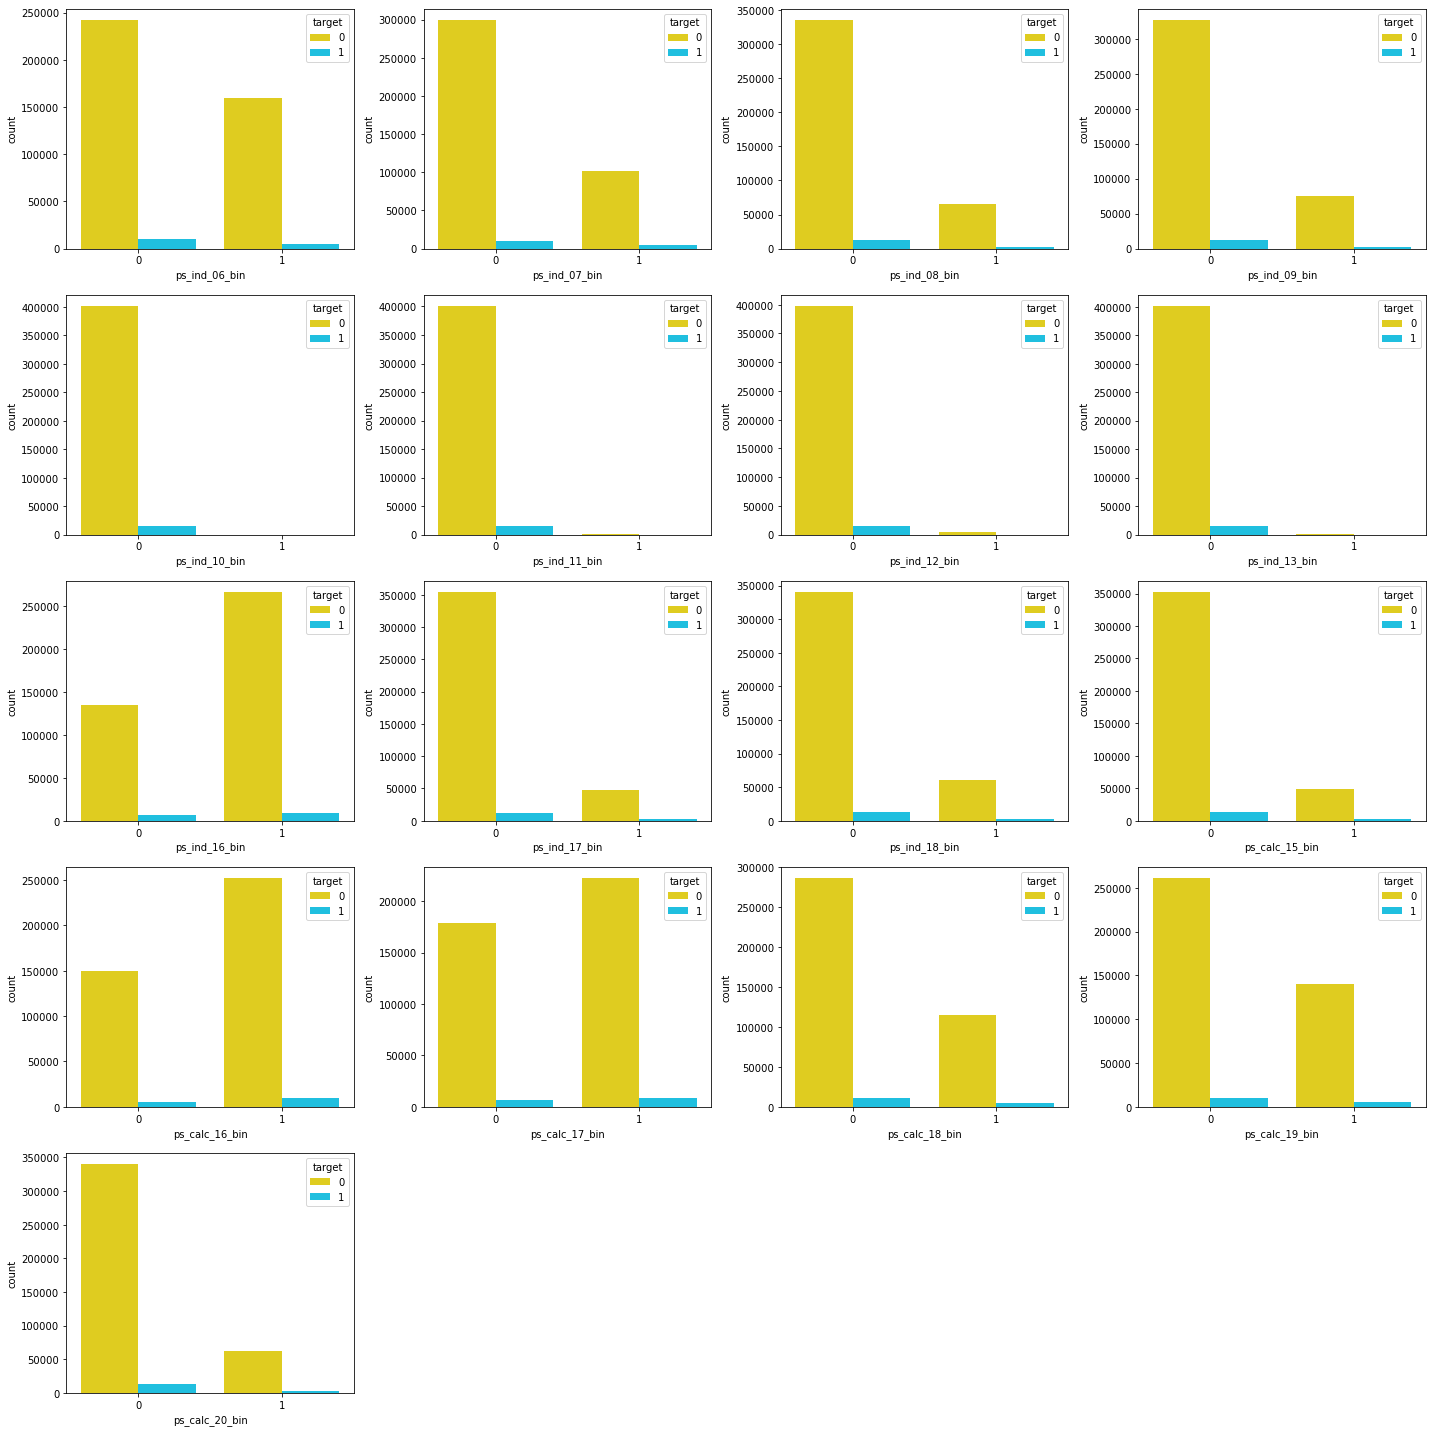

In [43]:
if(eda=='y'):
    plt.figure(figsize=(20,20))
    plt.title("Count plots of binary features")
    i=1
    for col in bin_cols:
        plt.subplot(5,4,i)
        i=i+1
        sns.countplot(bin_cols[col],hue=train_target,palette="jet_r")
        plt.tight_layout()

From the plots, it is evident that except some of the calc values, most features are dominated by a single value.

**Categorical data**

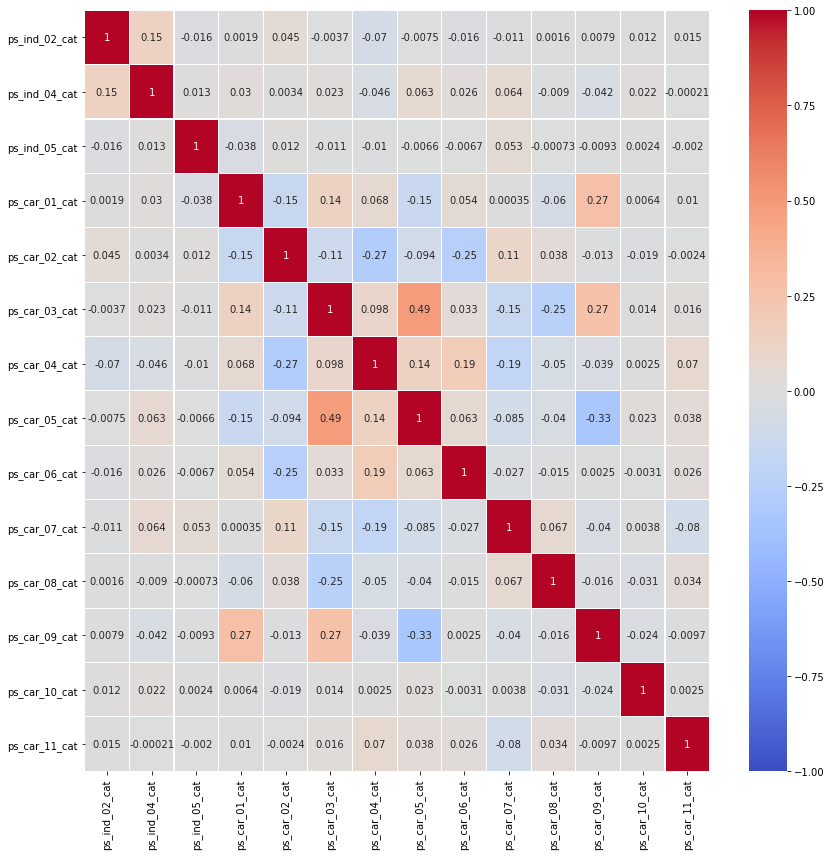

In [44]:
if(eda=='y'):
    plt.figure(figsize=(cat_cols.columns.nunique(),cat_cols.columns.nunique()))
    sns.heatmap(cat_cols.corr(), cmap="coolwarm",vmin=-1, annot=True, linewidths=0.1)

As in binary columns, there is no evident correlation between categorical columns.

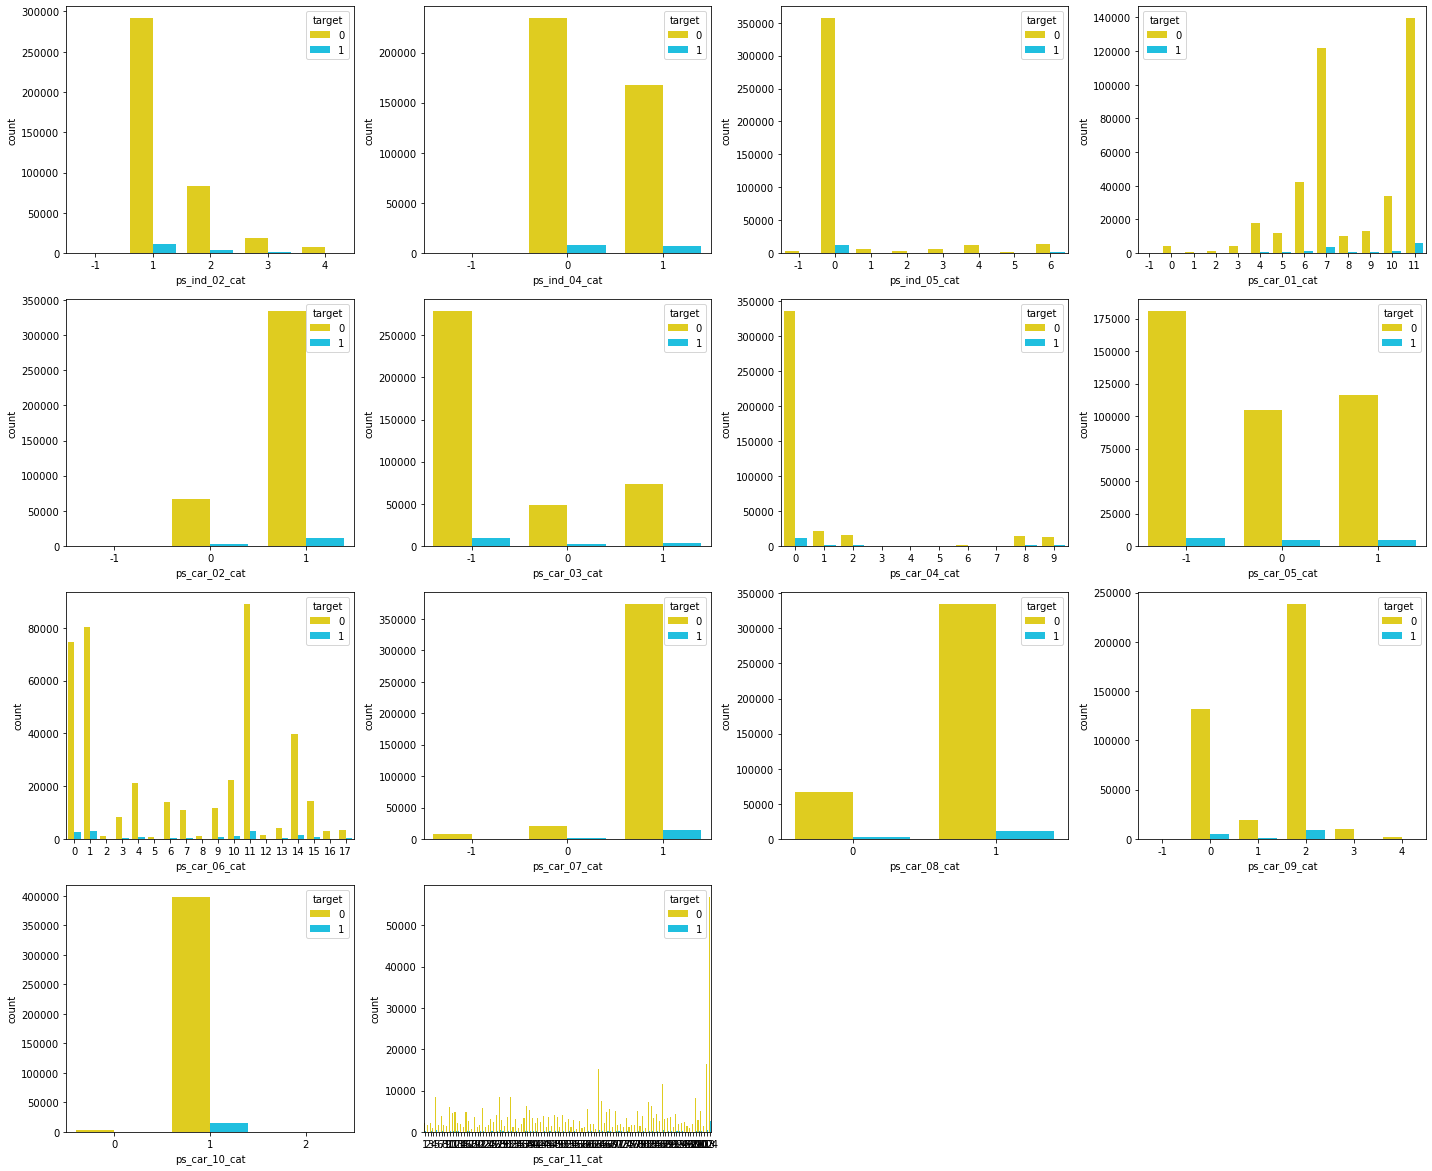

In [45]:
if(eda=='y'):
    plt.figure(figsize=(20,20))
    plt.title("Count plots of categorical features")
    i=1
    for col in cat_cols:
        plt.subplot(5,4,i)
        i=i+1
        sns.countplot(cat_cols[col],hue=train_target,palette="jet_r")
        plt.tight_layout()

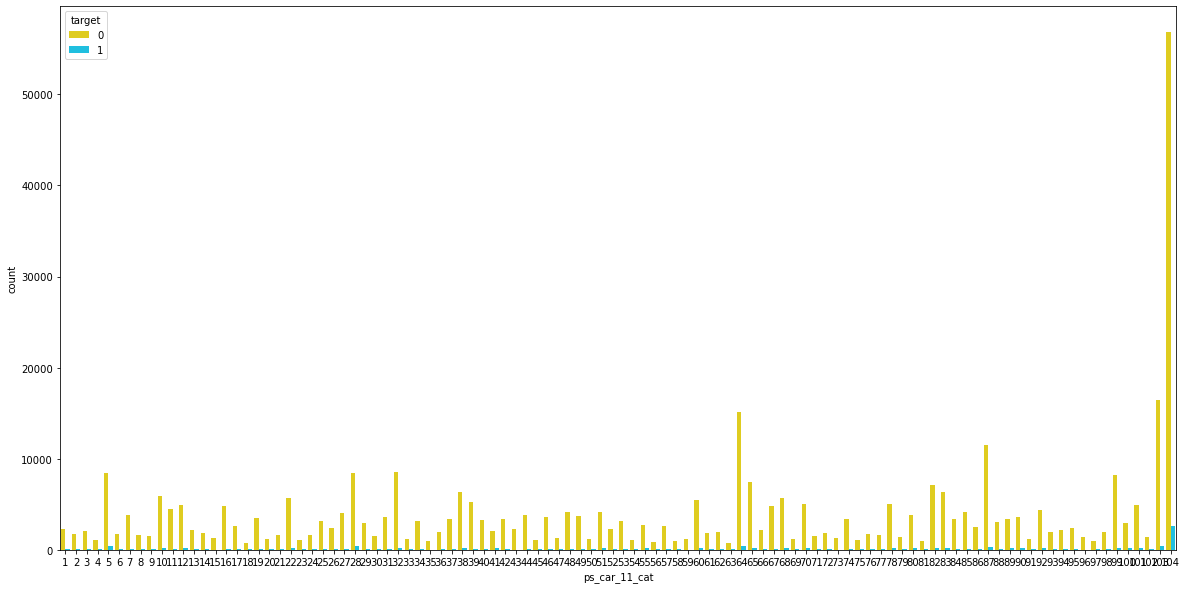

In [46]:
if(eda=='y'):
    plt.figure(figsize=(20,10))
    sns.countplot(cat_cols['ps_car_11_cat'],hue=train_target,palette="jet_r")

1. Some features like 'ps_ind_05_cat' and 'ps_car_04_cat' mostly consists of a single value. Therefore the mode of these features can be used for filling their missing values
2. We plan to replace the -1s with either mean, median or mode in categorical values.
3. In ps_car_03_cat and In ps_car_05_cat, there is a higher number of -1s, so we can either drop the column or treat -1 as a separate category.
4. After all this, we will go for techniques like OHE and Label encoding etc.

**Numerical data**

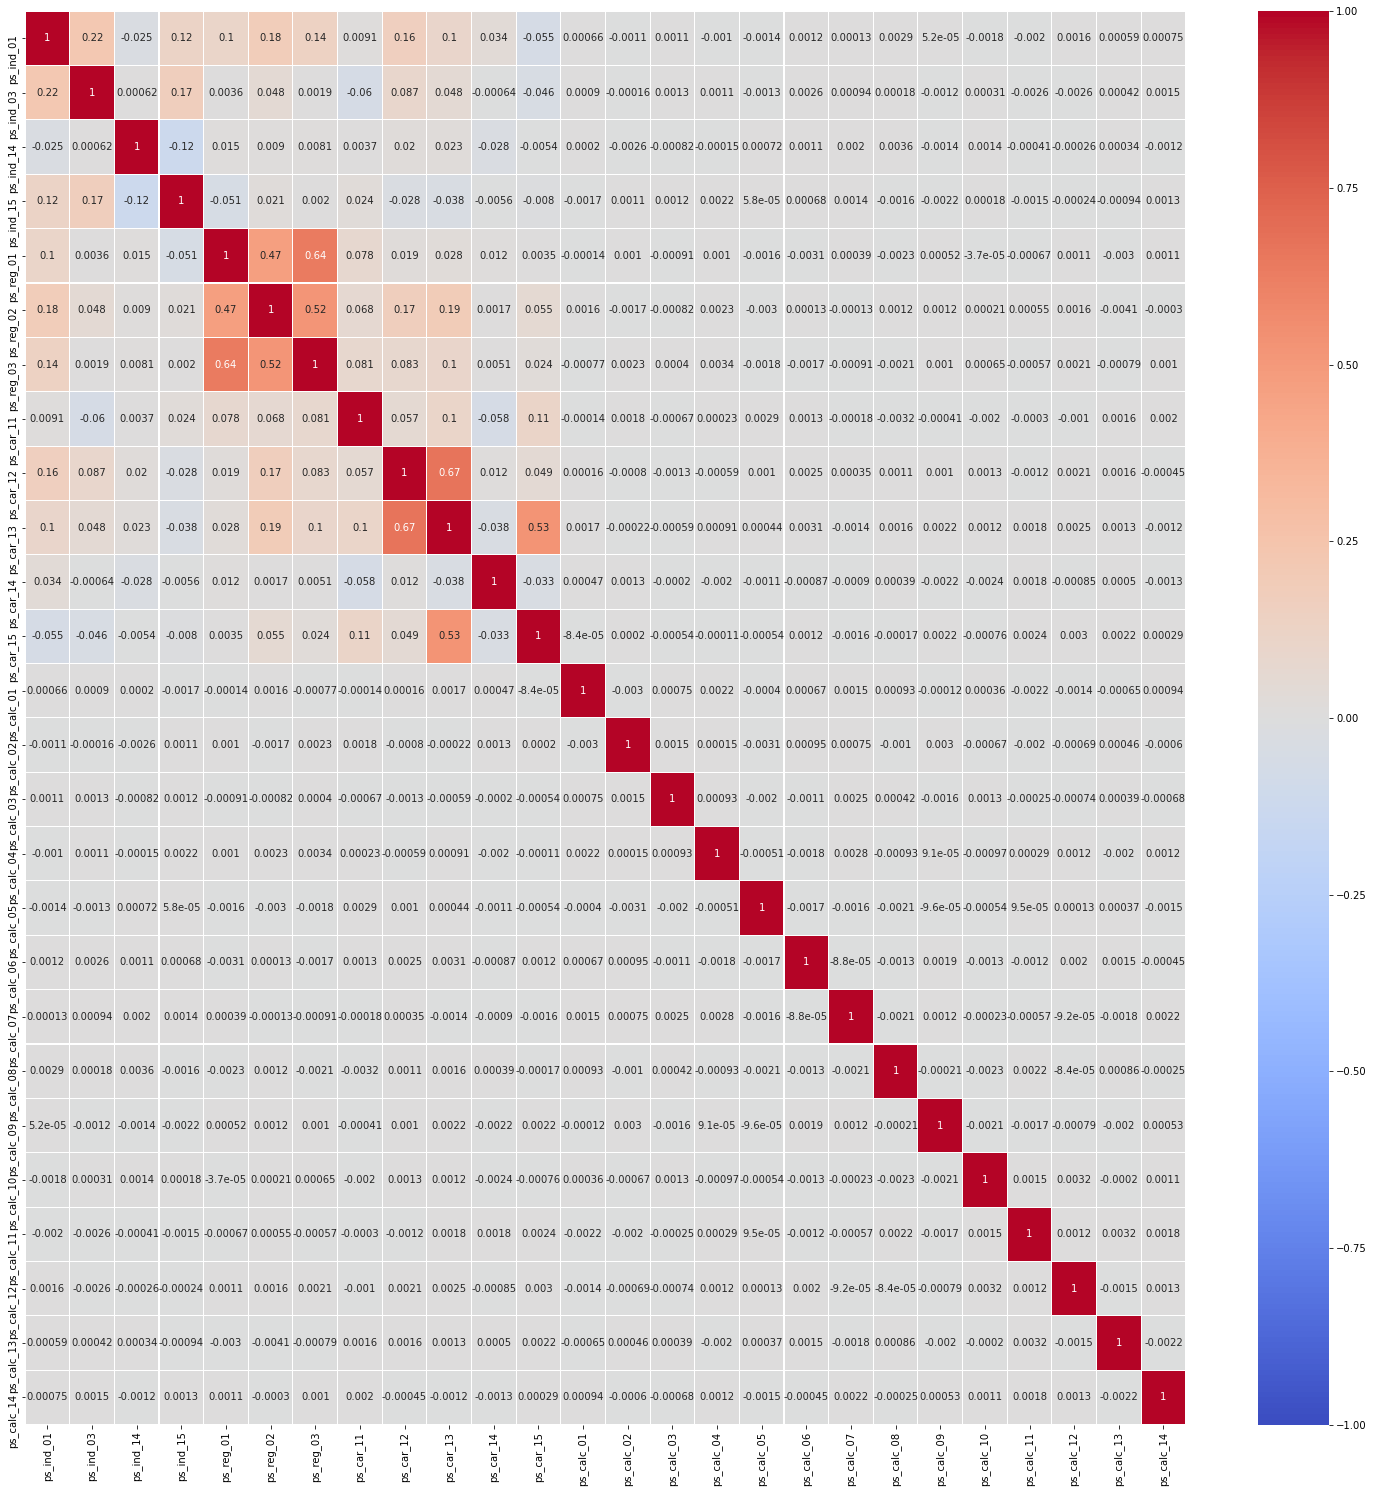

In [47]:
if(eda=='y'):
    plt.figure(figsize=(num_cols.columns.nunique(),num_cols.columns.nunique()))
    sns.heatmap(num_cols.corr(), cmap="coolwarm",vmin=-1, annot=True, linewidths=0.1)

In numerical columns, there is some correlation, though not enough to make a significant impact.

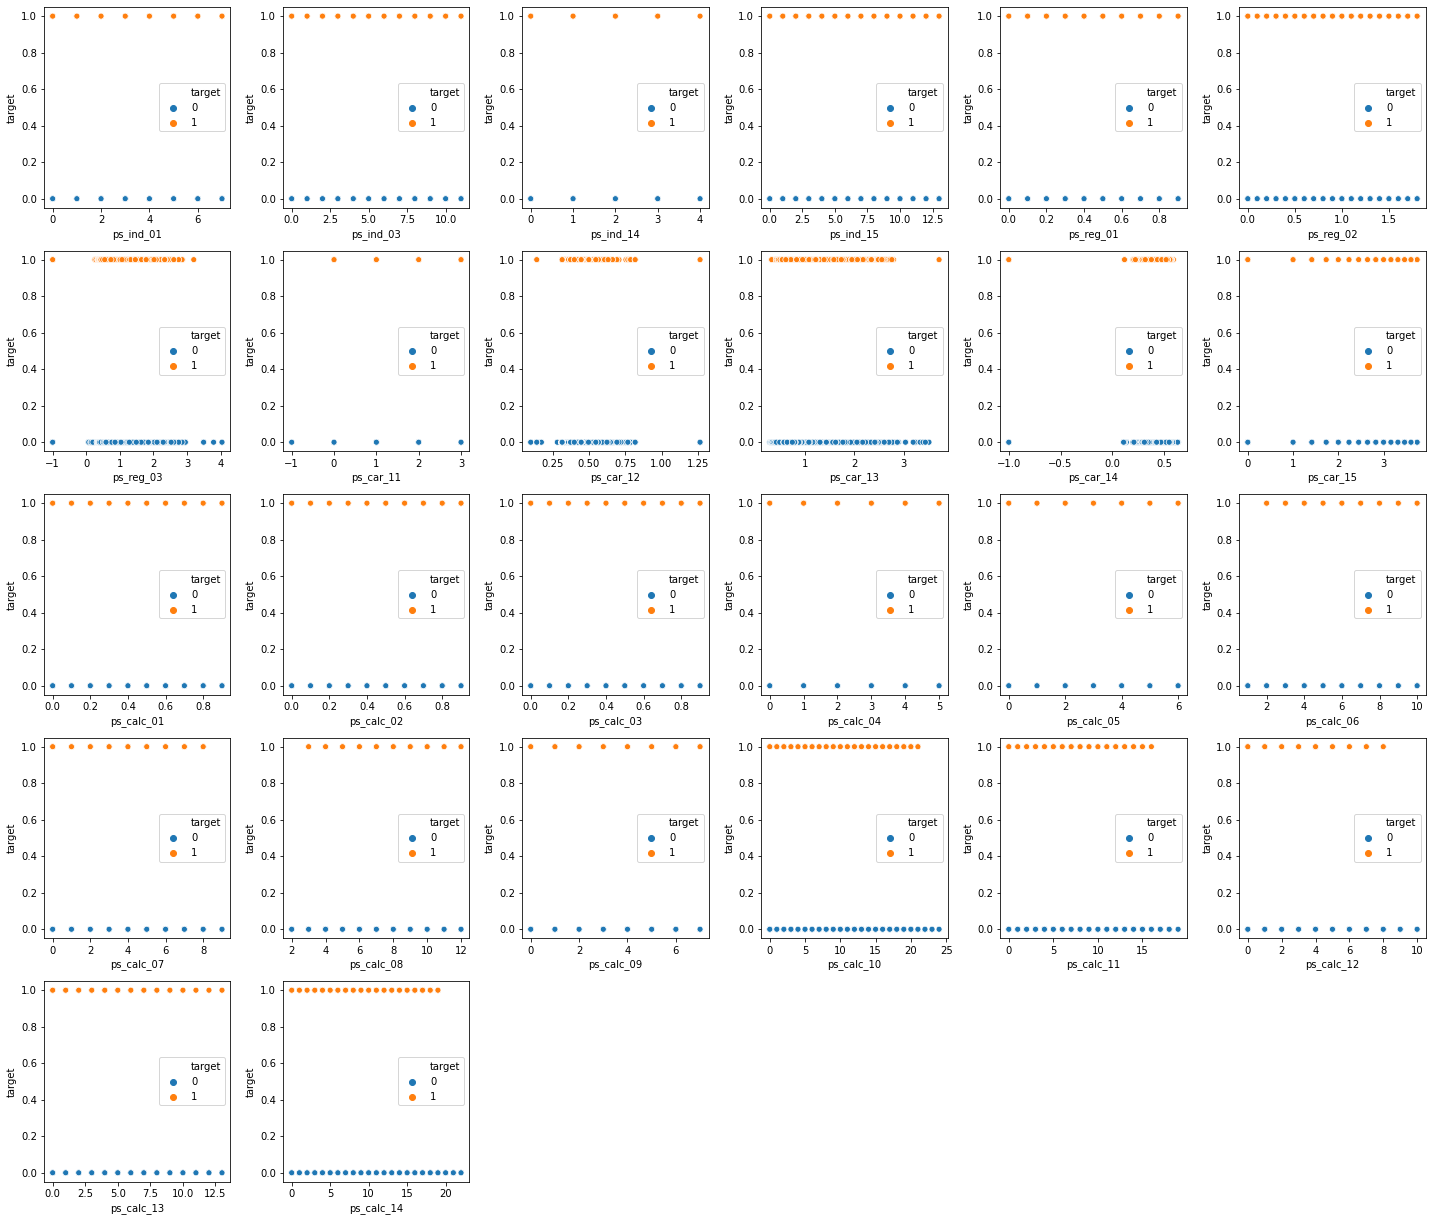

In [48]:
if(eda=='y'):
    plt.figure(figsize=(20,20))
    i=1
    for col in num_cols.columns:
        plt.subplot(6,6,i)
        i=i+1
        sns.scatterplot(x=col, y=train_target, hue=train_target, data=num_cols)
        plt.tight_layout()

We separate the numerical features into two separate datasets, one with calc and other without calc.

In [49]:
num_calc_cols = num_cols.loc[:,num_cols.columns.str.contains("calc")]
num_cols_no_calc = num_cols.drop(num_calc_cols.columns, axis=1)
num_cols = num_cols_no_calc

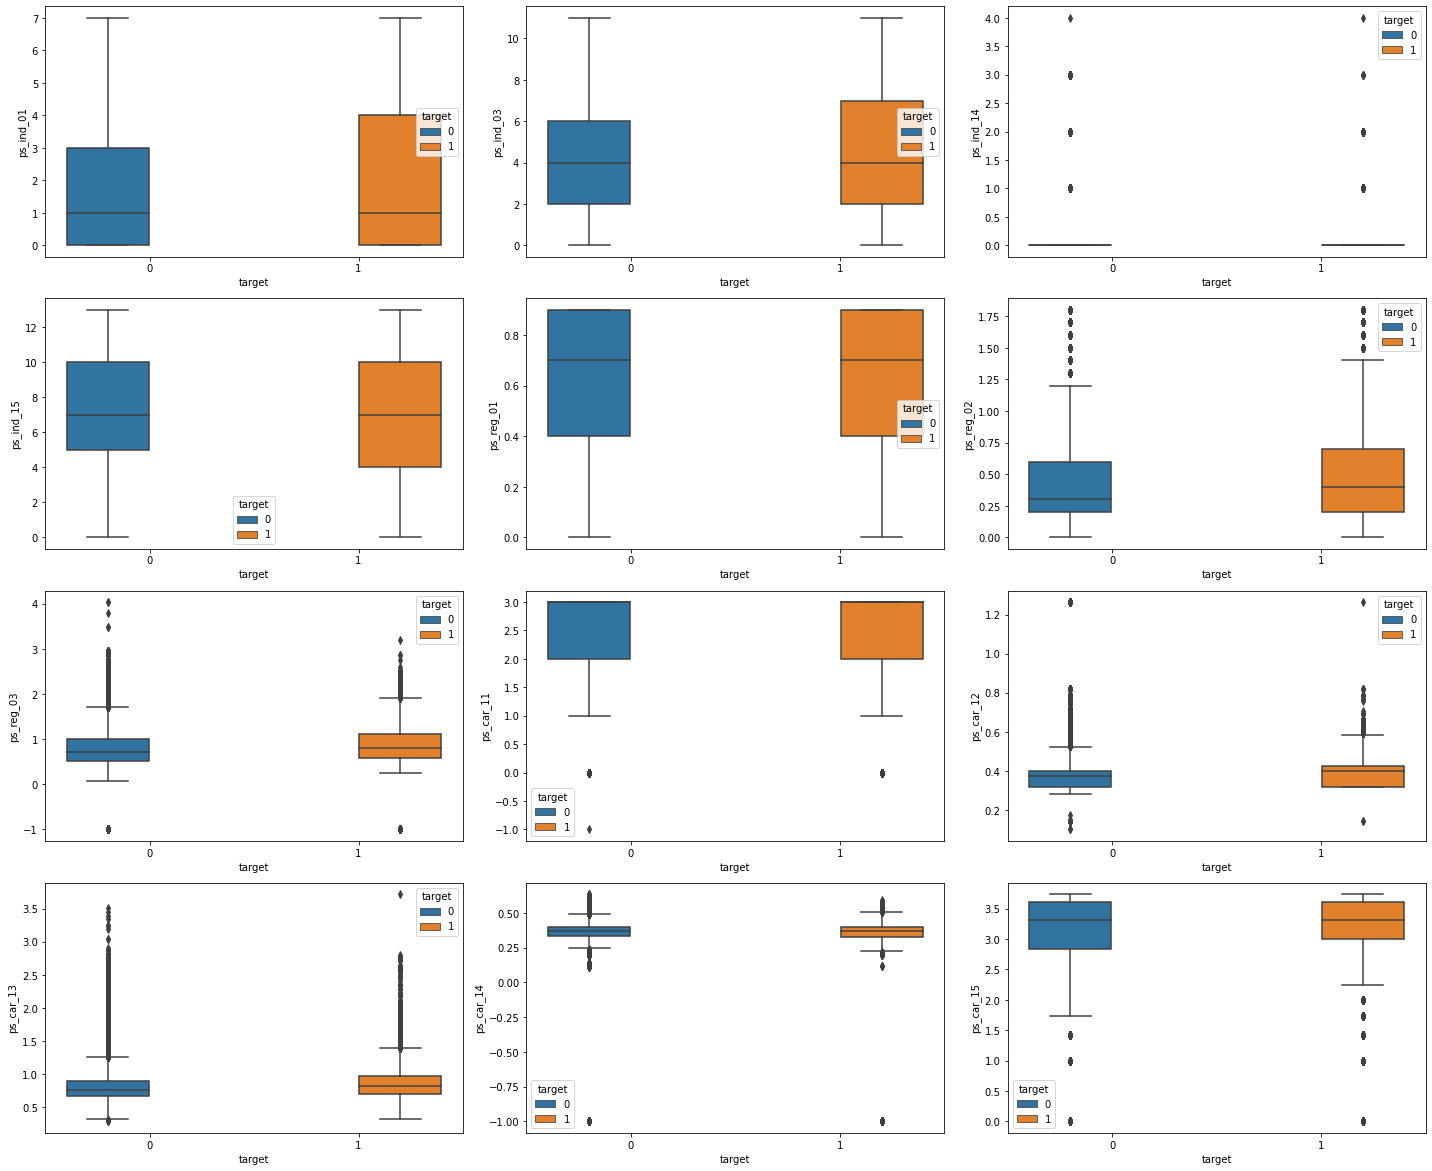

In [50]:
if(eda=='y'):
    plt.figure(figsize=(20,20))
    i=1
    for col in num_cols_no_calc:
        plt.subplot(5,3,i)
        i=i+1
        sns.boxplot(x=train_target, y=num_cols_no_calc[col], hue=train_target)
        plt.tight_layout()

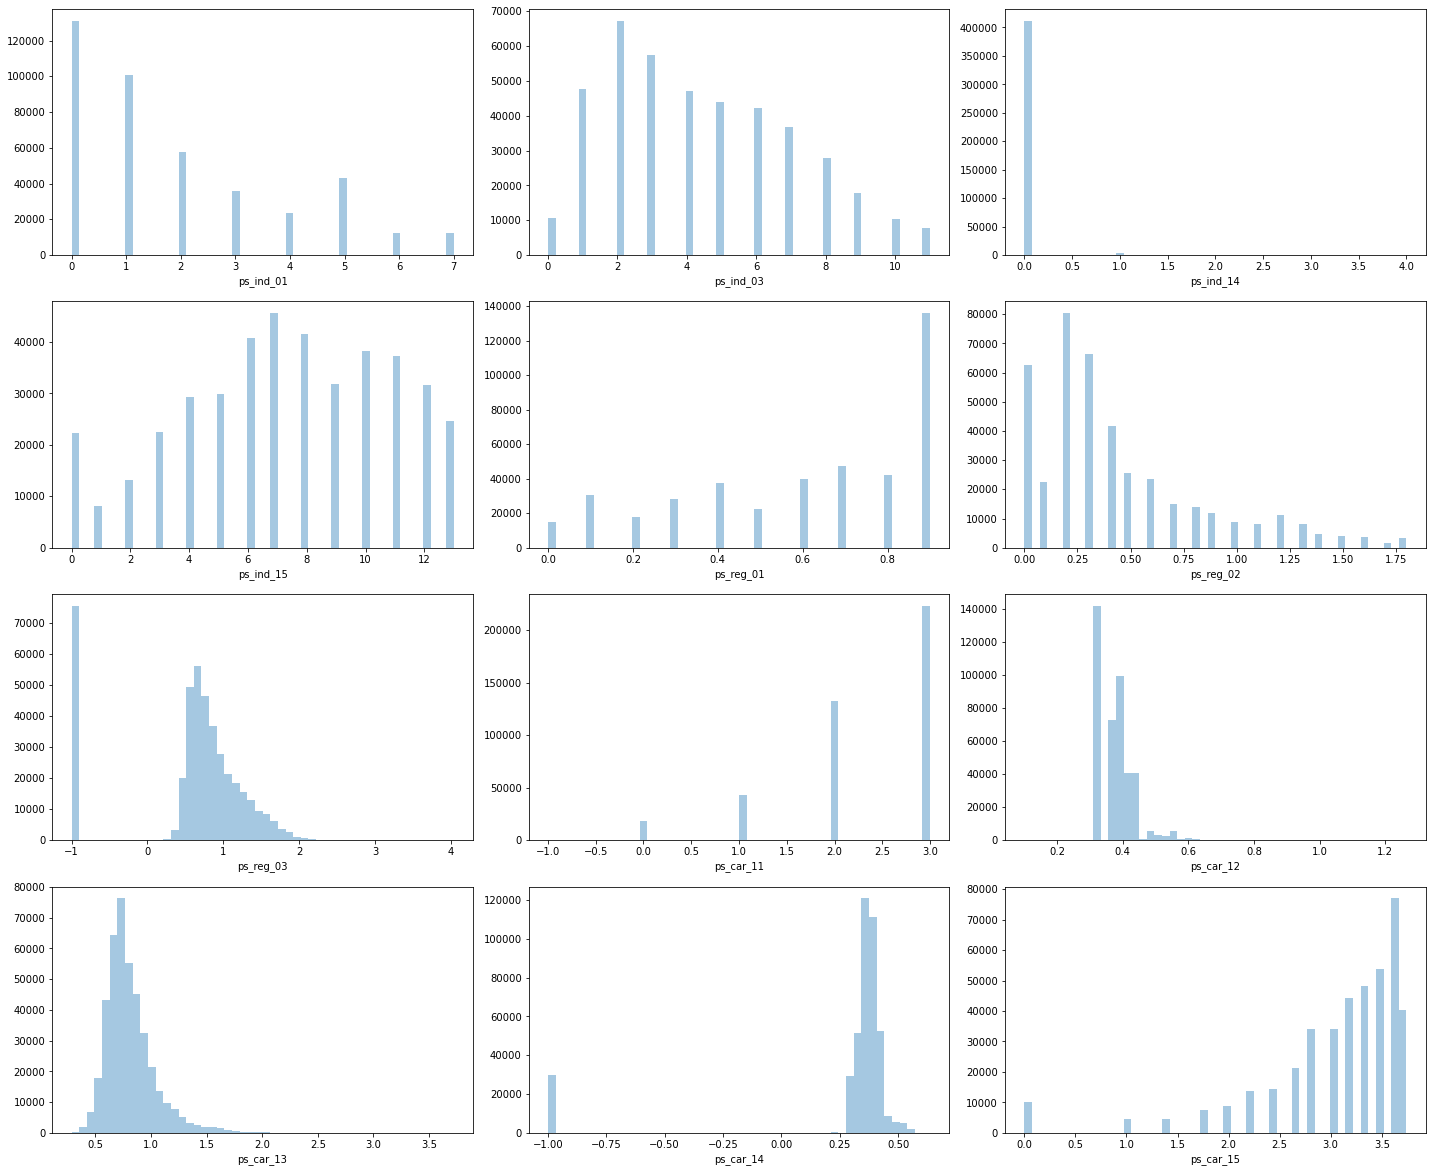

In [51]:
if(eda=='y'):
    plt.figure(figsize=(20,20))
    i=1
    for col in num_cols_no_calc:
        plt.subplot(5,3,i)
        i=i+1
        sns.distplot(num_cols_no_calc[col], kde=False)
        plt.tight_layout()

Now, for calc numerical columns

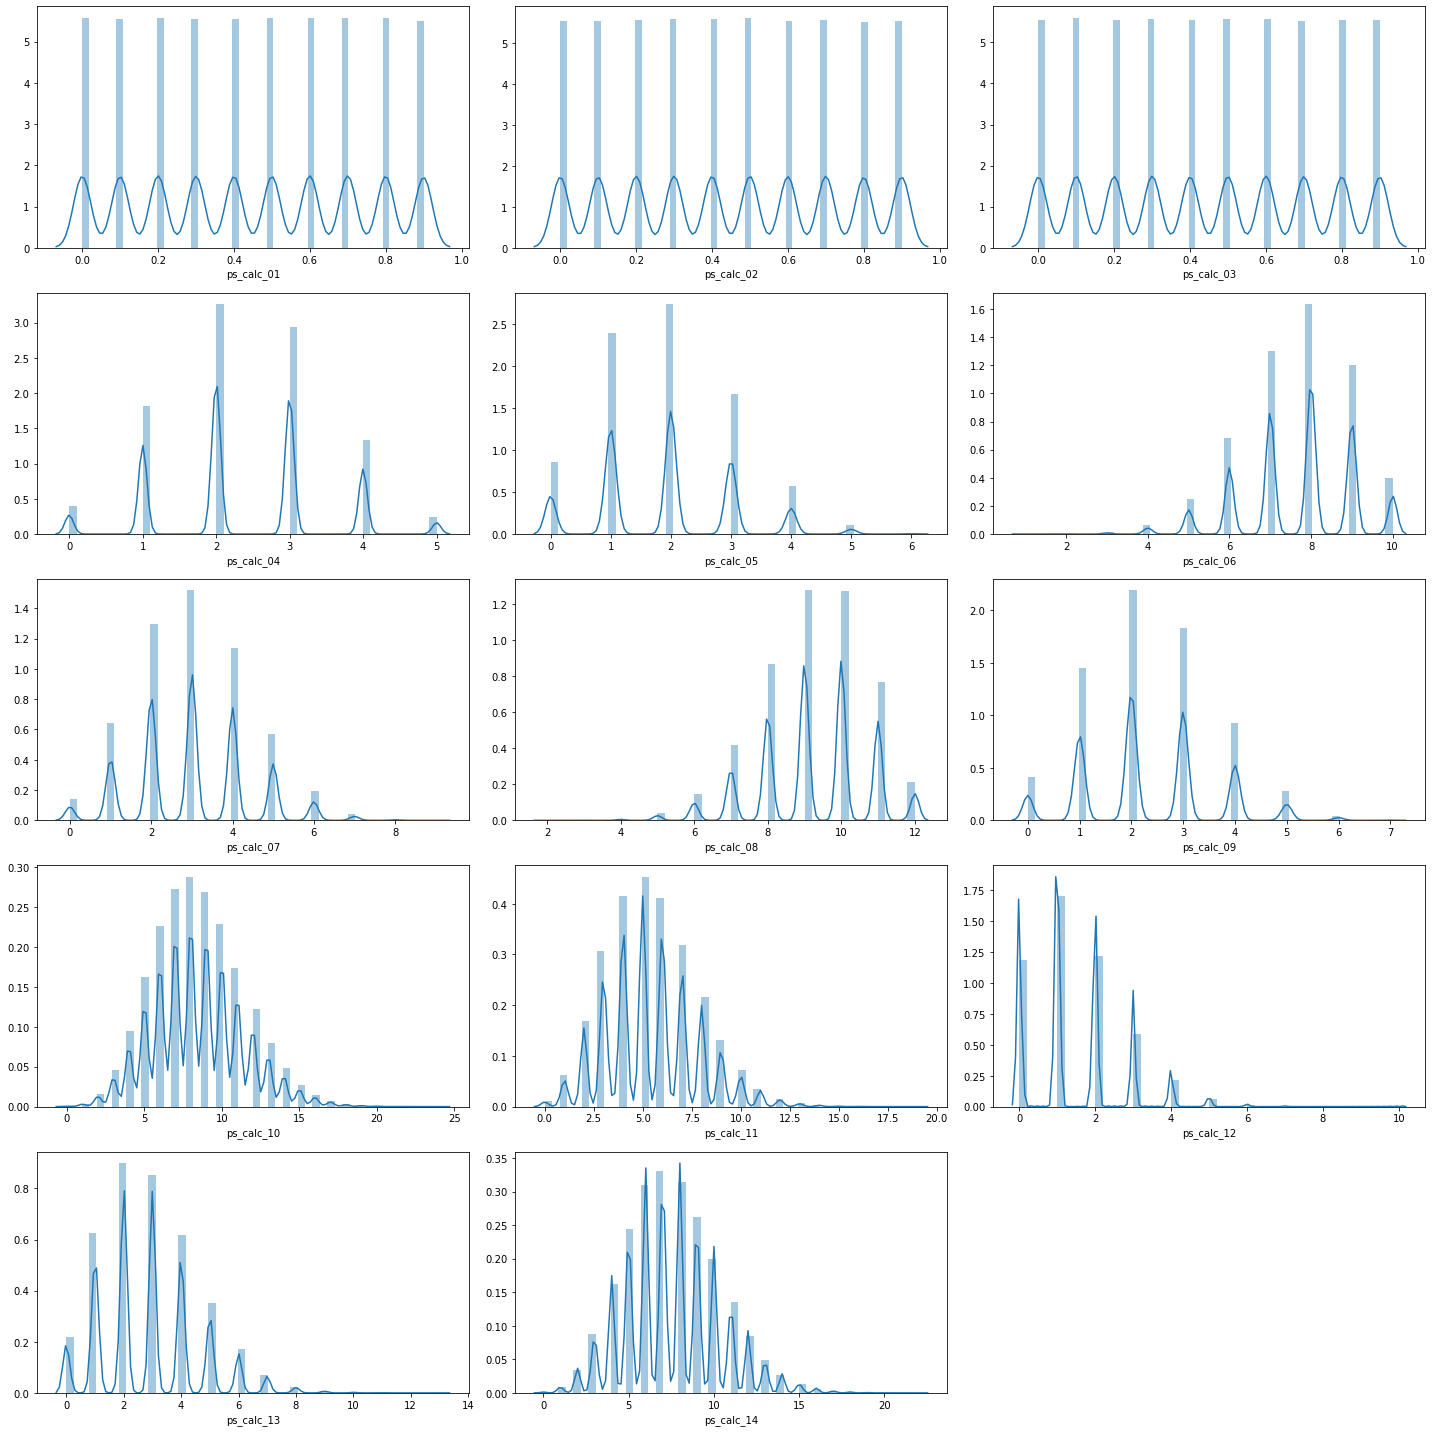

In [52]:
if(eda=='y'):
    plt.figure(figsize=(20,20))
    i=1
    for col in num_calc_cols:
        plt.subplot(5,3,i)
        i=i+1
        sns.distplot(num_calc_cols[col])
        plt.tight_layout()

We see that all the cal features have a normal distribution, which is a good thing. But the symmetry can cause a problem in classification. Also, since they are calculated features, the concerns of their relavance to the model arise. Hence, to confirm our suspicions over usability of calc features, we plot boxplots.

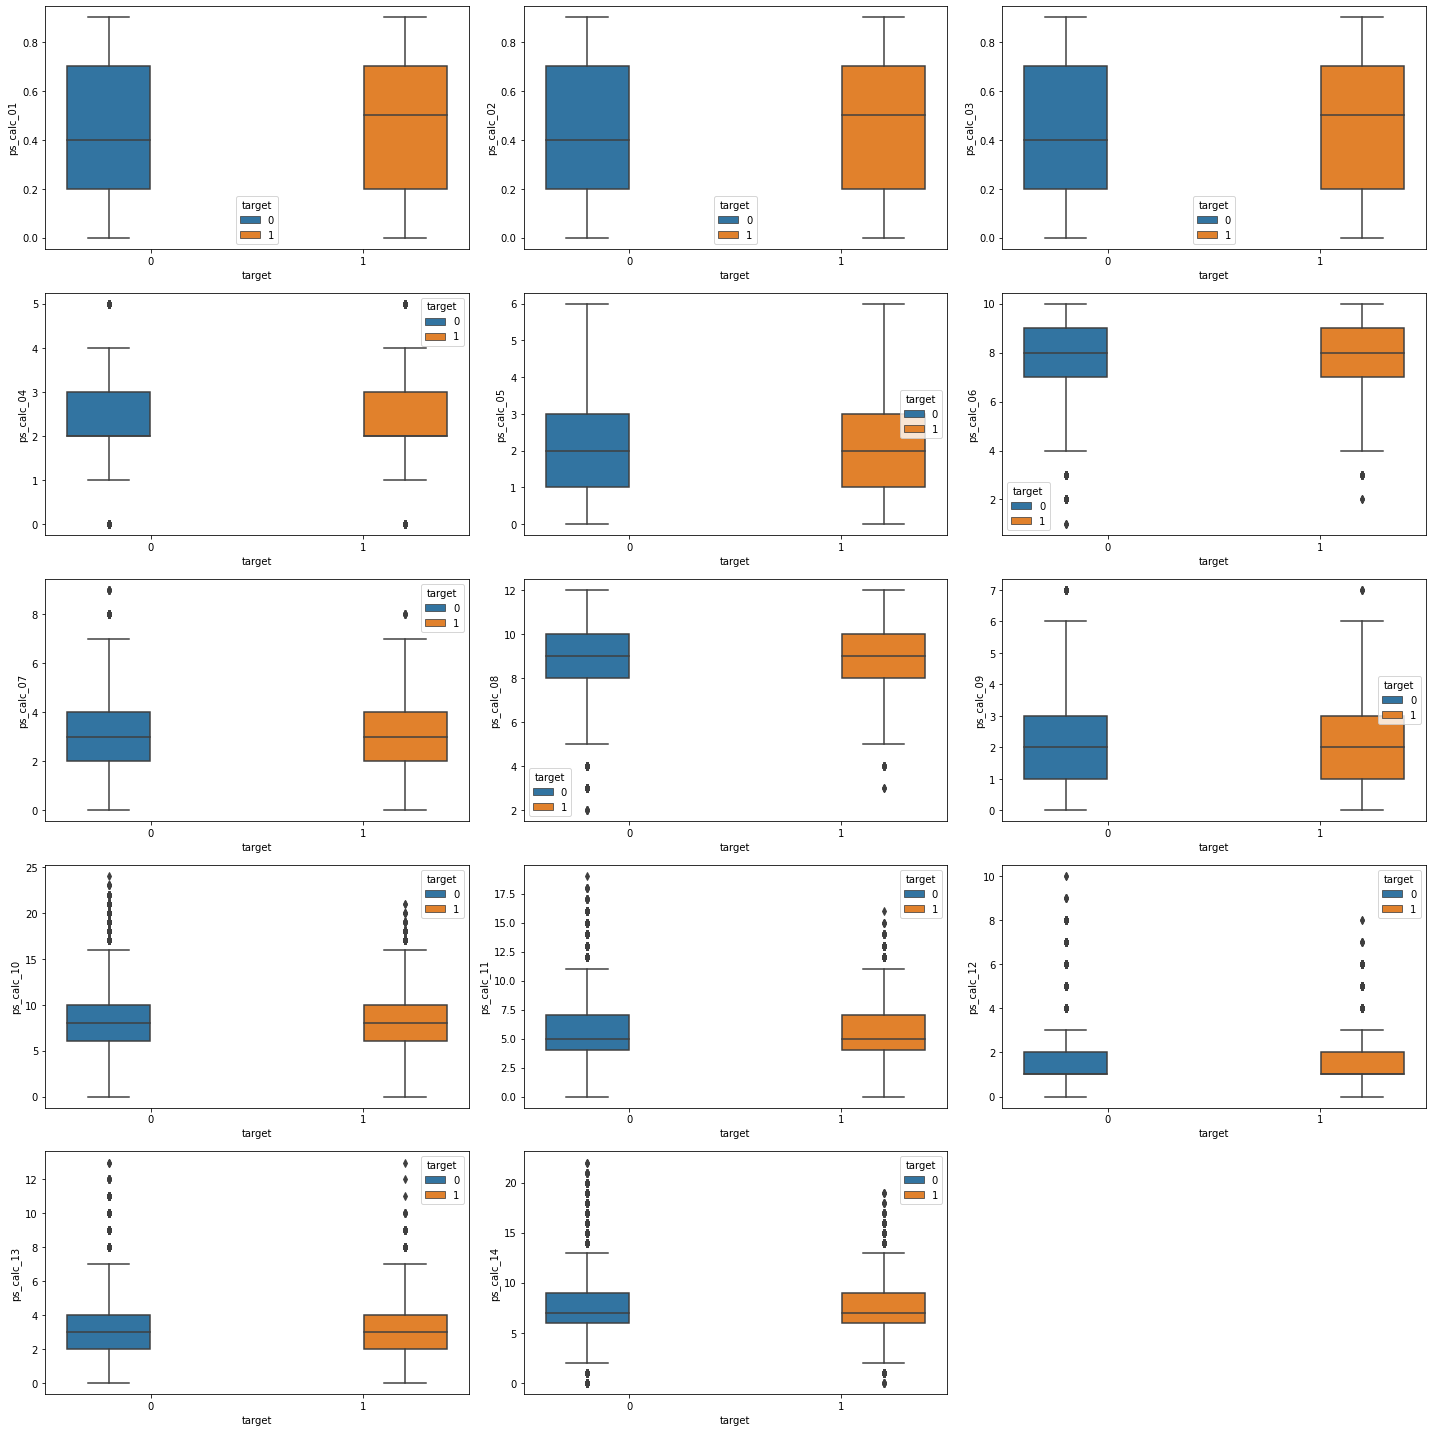

In [53]:
if(eda=='y'):
    plt.figure(figsize=(20,20))
    i=1
    for col in num_calc_cols:
        plt.subplot(5,3,i)
        i=i+1
        sns.boxplot(x=train_target, y=num_calc_cols[col], hue=train_target)
        plt.tight_layout()

As expected, we see that boxplots are more or like identical for both target 0 and 1. Hence, they behave as random noise and donot provide any relavant information to the model. So we choose to drop them.

1) LightGBM 

In [54]:
#
# lightgbm parameters
'''lgb_params = dict(
    learning_rate=[0.005, 0.01, 0.03],
    n_estimators=[500, 700, 900],
    reg_alpha=[2, 4, 6],
    reg_lambda=[2, 4, 6],
    num_leaves=[10, 20, 30],
    subsample=[0.7, 0.8, 0.9]
)
lg = lgbm.LGBMClassifier()
lg_rscv = RandomizedSearchCV(estimator=lg, param_distributions=lgb_params, verbose=1, cv=3, return_train_score=True, n_jobs=-1)
lg_rscv.fit(train, train_target)
print('Best Score: ', lg_rscv.best_score_)
print('Best Params: ', lg_rscv.best_params_)'''

"lgb_params = dict(\n    learning_rate=[0.005, 0.01, 0.03],\n    n_estimators=[500, 700, 900],\n    reg_alpha=[2, 4, 6],\n    reg_lambda=[2, 4, 6],\n    num_leaves=[10, 20, 30],\n    subsample=[0.7, 0.8, 0.9]\n)\nlg = lgbm.LGBMClassifier()\nlg_rscv = RandomizedSearchCV(estimator=lg, param_distributions=lgb_params, verbose=1, cv=3, return_train_score=True, n_jobs=-1)\nlg_rscv.fit(train, train_target)\nprint('Best Score: ', lg_rscv.best_score_)\nprint('Best Params: ', lg_rscv.best_params_)"

In [55]:
# After a little tweaking, we finally adjusted on the following parameters
params = {
    "objective":'binary',
    "boosting_type":"gbdt",
    "is_unbalance":True,
    "learning_rate":0.01,
    "n_estimators":700,
    "reg_alpha":4,
    "reg_lambda":4,
    "num_leaves":10,
    "subsample":0.8
}
lg = lgbm.LGBMClassifier(**params)


i=1
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)
for train_index, test_index in kf.split(train, train_target):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = train_target[train_index], train_target[test_index]
    lg.fit(x_train, y_train)
    ans = lg.predict_proba(x_test)[:,1]
    g = gini_normalized(y_test, ans)
    print("KFold {}: {}".format(i,g))
    i=i+1

KFold 1: 0.28155810649253377
KFold 2: 0.26645482151765315
KFold 3: 0.26652004279287167


In [56]:
lg.fit(train, train_target)
ans_lgb = lg.predict_proba(test)[:,1]

Feature importances

In [57]:
feat_imp = pd.DataFrame({"Feature":train.columns, "Importance":lg.feature_importances_},index=range(1,len(train.columns)+1))
feat_imp

,Feature,Importance
1,ps_ind_01,345
2,ps_ind_02_cat,231
3,ps_ind_03,767
4,ps_ind_04_cat,125
5,ps_ind_05_cat,329
6,ps_ind_06_bin,37
7,ps_ind_07_bin,73
8,ps_ind_08_bin,55
9,ps_ind_09_bin,81
10,ps_ind_10_bin,0


In [58]:
zero_imp = feat_imp[feat_imp["Importance"]==0]
list(zero_imp["Feature"])

['ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_calc_20_bin']

In [59]:
train.drop(columns=list(zero_imp["Feature"]),inplace=True)
test.drop(columns=list(zero_imp["Feature"]),inplace=True)

num_cols.drop(columns=['ps_ind_14'],inplace=True)
bin_cols.drop(columns=['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin',
'ps_calc_20_bin'],inplace=True)

# Pre-processing the data

Imputing missing values:

**1) Numerical columns**

We impute like this ->

     column      metric
    ps_reg_03     mean
    ps_car_11     mode
    ps_car_14     mean


**2) Categorical columns**

We impute with the strategy as mode ->

       column        metric
    ps_ind_02_cat     mode
    ps_ind_04_cat     mode
    ps_ind_05_cat     mode
    ps_car_01_cat     mode
    ps_car_02_cat     mode
    ps_car_07_cat     mode
    ps_car_09_cat     mode

    ps_car_03_cat     TaS*
    ps_car_05_cat     TaS*
    *Treated as separate

**3) Binary columns**

They don't have any missing values.

2) Catboost

In [60]:
#
# catboost parameters
parameters = dict(
    n_estimators = [1000, 1500, 2000],
    learning_rate = [0.01, 0.03, 0.05],
    depth = [5, 7, 9]
)

cat = catboost.CatBoostClassifier(verbose=False)
cat_rscv = RandomizedSearchCV(estimator=cat, param_distributions=parameters, verbose=1, cv=3, return_train_score=True, n_jobs=-1)

cat_rscv.fit(train, train_target)
print('Best Score: ', cat_rscv.best_score_)
print('Best Params: ', cat_rscv.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 86.6min finished


Best Score:  0.9634703634776232
Best Params:  {'n_estimators': 1500, 'learning_rate': 0.05, 'depth': 7}


In [62]:
#
#cat = catboost.CatBoostClassifier(**cat_rscv.best_params_)
#cat.fit(train_X, target_X)
#train_val = cat.predict_proba(train_X)[:,1]
#test_val = cat.predict_proba(train_CV)[:,1]
#print(gini_normalized(target_CV, test_val))

In [ ]:
# plots of various scoring metrics
#if(eda=='y'):
#    get_scoring_plots(train_val, test_val, target_X, target_CV)

In [63]:
#
cat = catboost.CatBoostClassifier(n_estimators=1000, learning_rate=0.03, depth=7)
cat.fit(train, train_target)
ans_cat = cat.predict_proba(test)[:,1]

0:	learn: 0.6483821	total: 160ms	remaining: 2m 40s
1:	learn: 0.6076138	total: 282ms	remaining: 2m 20s
2:	learn: 0.5700830	total: 413ms	remaining: 2m 17s
3:	learn: 0.5356315	total: 547ms	remaining: 2m 16s
4:	learn: 0.5041517	total: 688ms	remaining: 2m 16s
5:	learn: 0.4752419	total: 818ms	remaining: 2m 15s
6:	learn: 0.4490503	total: 947ms	remaining: 2m 14s
7:	learn: 0.4247686	total: 1.1s	remaining: 2m 16s
8:	learn: 0.4028309	total: 1.23s	remaining: 2m 15s
9:	learn: 0.3824502	total: 1.37s	remaining: 2m 16s
10:	learn: 0.3640566	total: 1.5s	remaining: 2m 15s
11:	learn: 0.3471825	total: 1.64s	remaining: 2m 15s
12:	learn: 0.3316682	total: 1.78s	remaining: 2m 15s
13:	learn: 0.3176086	total: 1.91s	remaining: 2m 14s
14:	learn: 0.3048458	total: 2.04s	remaining: 2m 14s
15:	learn: 0.2931104	total: 2.16s	remaining: 2m 12s
16:	learn: 0.2823722	total: 2.29s	remaining: 2m 12s
17:	learn: 0.2724589	total: 2.41s	remaining: 2m 11s
18:	learn: 0.2633638	total: 2.54s	remaining: 2m 11s
19:	learn: 0.2550885	tot

158:	learn: 0.1517540	total: 24.4s	remaining: 2m 9s
159:	learn: 0.1517376	total: 24.6s	remaining: 2m 9s
160:	learn: 0.1517262	total: 24.8s	remaining: 2m 9s
161:	learn: 0.1517116	total: 25s	remaining: 2m 9s
162:	learn: 0.1517013	total: 25.1s	remaining: 2m 9s
163:	learn: 0.1516855	total: 25.3s	remaining: 2m 8s
164:	learn: 0.1516695	total: 25.4s	remaining: 2m 8s
165:	learn: 0.1516607	total: 25.6s	remaining: 2m 8s
166:	learn: 0.1516421	total: 25.7s	remaining: 2m 8s
167:	learn: 0.1516339	total: 25.9s	remaining: 2m 8s
168:	learn: 0.1516267	total: 26s	remaining: 2m 7s
169:	learn: 0.1516184	total: 26.2s	remaining: 2m 7s
170:	learn: 0.1515999	total: 26.3s	remaining: 2m 7s
171:	learn: 0.1515886	total: 26.4s	remaining: 2m 7s
172:	learn: 0.1515716	total: 26.6s	remaining: 2m 7s
173:	learn: 0.1515528	total: 26.7s	remaining: 2m 6s
174:	learn: 0.1515399	total: 26.8s	remaining: 2m 6s
175:	learn: 0.1515265	total: 27s	remaining: 2m 6s
176:	learn: 0.1515130	total: 27.1s	remaining: 2m 6s
177:	learn: 0.1515

316:	learn: 0.1499939	total: 47.3s	remaining: 1m 41s
317:	learn: 0.1499856	total: 47.5s	remaining: 1m 41s
318:	learn: 0.1499749	total: 47.6s	remaining: 1m 41s
319:	learn: 0.1499680	total: 47.7s	remaining: 1m 41s
320:	learn: 0.1499577	total: 47.9s	remaining: 1m 41s
321:	learn: 0.1499474	total: 48s	remaining: 1m 41s
322:	learn: 0.1499358	total: 48.2s	remaining: 1m 40s
323:	learn: 0.1499242	total: 48.3s	remaining: 1m 40s
324:	learn: 0.1499164	total: 48.4s	remaining: 1m 40s
325:	learn: 0.1499124	total: 48.6s	remaining: 1m 40s
326:	learn: 0.1499061	total: 48.7s	remaining: 1m 40s
327:	learn: 0.1499013	total: 48.8s	remaining: 1m 40s
328:	learn: 0.1498946	total: 48.9s	remaining: 1m 39s
329:	learn: 0.1498840	total: 49.1s	remaining: 1m 39s
330:	learn: 0.1498770	total: 49.2s	remaining: 1m 39s
331:	learn: 0.1498672	total: 49.4s	remaining: 1m 39s
332:	learn: 0.1498573	total: 49.5s	remaining: 1m 39s
333:	learn: 0.1498488	total: 49.6s	remaining: 1m 38s
334:	learn: 0.1498393	total: 49.8s	remaining: 1m

472:	learn: 0.1486117	total: 1m 8s	remaining: 1m 16s
473:	learn: 0.1486007	total: 1m 8s	remaining: 1m 16s
474:	learn: 0.1485952	total: 1m 8s	remaining: 1m 16s
475:	learn: 0.1485872	total: 1m 9s	remaining: 1m 16s
476:	learn: 0.1485813	total: 1m 9s	remaining: 1m 15s
477:	learn: 0.1485731	total: 1m 9s	remaining: 1m 15s
478:	learn: 0.1485671	total: 1m 9s	remaining: 1m 15s
479:	learn: 0.1485587	total: 1m 9s	remaining: 1m 15s
480:	learn: 0.1485508	total: 1m 9s	remaining: 1m 15s
481:	learn: 0.1485467	total: 1m 9s	remaining: 1m 15s
482:	learn: 0.1485394	total: 1m 10s	remaining: 1m 15s
483:	learn: 0.1485275	total: 1m 10s	remaining: 1m 14s
484:	learn: 0.1485171	total: 1m 10s	remaining: 1m 14s
485:	learn: 0.1485101	total: 1m 10s	remaining: 1m 14s
486:	learn: 0.1485042	total: 1m 10s	remaining: 1m 14s
487:	learn: 0.1484913	total: 1m 10s	remaining: 1m 14s
488:	learn: 0.1484885	total: 1m 10s	remaining: 1m 14s
489:	learn: 0.1484831	total: 1m 11s	remaining: 1m 13s
490:	learn: 0.1484704	total: 1m 11s	re

628:	learn: 0.1473740	total: 1m 31s	remaining: 53.7s
629:	learn: 0.1473671	total: 1m 31s	remaining: 53.5s
630:	learn: 0.1473574	total: 1m 31s	remaining: 53.4s
631:	learn: 0.1473522	total: 1m 31s	remaining: 53.2s
632:	learn: 0.1473417	total: 1m 31s	remaining: 53.1s
633:	learn: 0.1473335	total: 1m 31s	remaining: 53s
634:	learn: 0.1473277	total: 1m 31s	remaining: 52.8s
635:	learn: 0.1473166	total: 1m 31s	remaining: 52.6s
636:	learn: 0.1473099	total: 1m 32s	remaining: 52.5s
637:	learn: 0.1473034	total: 1m 32s	remaining: 52.3s
638:	learn: 0.1472905	total: 1m 32s	remaining: 52.2s
639:	learn: 0.1472824	total: 1m 32s	remaining: 52s
640:	learn: 0.1472795	total: 1m 32s	remaining: 51.9s
641:	learn: 0.1472742	total: 1m 32s	remaining: 51.7s
642:	learn: 0.1472670	total: 1m 32s	remaining: 51.6s
643:	learn: 0.1472591	total: 1m 33s	remaining: 51.4s
644:	learn: 0.1472527	total: 1m 33s	remaining: 51.3s
645:	learn: 0.1472401	total: 1m 33s	remaining: 51.1s
646:	learn: 0.1472346	total: 1m 33s	remaining: 51s

784:	learn: 0.1462300	total: 1m 52s	remaining: 30.8s
785:	learn: 0.1462174	total: 1m 52s	remaining: 30.7s
786:	learn: 0.1462110	total: 1m 52s	remaining: 30.5s
787:	learn: 0.1461989	total: 1m 52s	remaining: 30.4s
788:	learn: 0.1461921	total: 1m 53s	remaining: 30.3s
789:	learn: 0.1461828	total: 1m 53s	remaining: 30.1s
790:	learn: 0.1461756	total: 1m 53s	remaining: 30s
791:	learn: 0.1461674	total: 1m 53s	remaining: 29.8s
792:	learn: 0.1461649	total: 1m 53s	remaining: 29.7s
793:	learn: 0.1461600	total: 1m 53s	remaining: 29.5s
794:	learn: 0.1461545	total: 1m 53s	remaining: 29.4s
795:	learn: 0.1461481	total: 1m 54s	remaining: 29.2s
796:	learn: 0.1461383	total: 1m 54s	remaining: 29.1s
797:	learn: 0.1461314	total: 1m 54s	remaining: 28.9s
798:	learn: 0.1461289	total: 1m 54s	remaining: 28.8s
799:	learn: 0.1461188	total: 1m 54s	remaining: 28.6s
800:	learn: 0.1461106	total: 1m 54s	remaining: 28.5s
801:	learn: 0.1461013	total: 1m 54s	remaining: 28.4s
802:	learn: 0.1460983	total: 1m 54s	remaining: 2

942:	learn: 0.1450685	total: 2m 14s	remaining: 8.14s
943:	learn: 0.1450583	total: 2m 14s	remaining: 7.99s
944:	learn: 0.1450494	total: 2m 14s	remaining: 7.86s
945:	learn: 0.1450456	total: 2m 15s	remaining: 7.72s
946:	learn: 0.1450329	total: 2m 15s	remaining: 7.58s
947:	learn: 0.1450217	total: 2m 15s	remaining: 7.44s
948:	learn: 0.1450152	total: 2m 15s	remaining: 7.3s
949:	learn: 0.1450061	total: 2m 15s	remaining: 7.16s
950:	learn: 0.1449979	total: 2m 16s	remaining: 7.01s
951:	learn: 0.1449953	total: 2m 16s	remaining: 6.87s
952:	learn: 0.1449894	total: 2m 16s	remaining: 6.73s
953:	learn: 0.1449842	total: 2m 16s	remaining: 6.59s
954:	learn: 0.1449811	total: 2m 16s	remaining: 6.44s
955:	learn: 0.1449770	total: 2m 16s	remaining: 6.3s
956:	learn: 0.1449676	total: 2m 17s	remaining: 6.16s
957:	learn: 0.1449605	total: 2m 17s	remaining: 6.01s
958:	learn: 0.1449536	total: 2m 17s	remaining: 5.87s
959:	learn: 0.1449446	total: 2m 17s	remaining: 5.73s
960:	learn: 0.1449346	total: 2m 17s	remaining: 5

**Filling in missing values**

In [64]:
# Numerical columns
num_cols = impute(num_cols, ['ps_reg_03', 'ps_car_14'], 'mean')
num_cols = impute(num_cols, ['ps_car_11'], 'most_frequent')

# Categorical columns
# whether to do this or not, check again
cat_cols = impute(cat_cols, ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_07_cat', 'ps_car_09_cat'], 'most_frequent')

In [65]:
training_data = pd.concat([num_cols,cat_cols,bin_cols],axis=1)

# making sure that the train and test datasets have same columns
print("Train: ",training_data.columns.nunique())
cls = training_data.columns
testing_data = test[cls]
print("Test: ",testing_data.columns.nunique())

Train:  37
Test:  37


Encoding

In [66]:
train_ohe, test_ohe = one_hot_encode(training_data, testing_data, cat_cols.columns)

Upsampling

In [67]:
X = pd.concat([train_ohe, train_target], axis=1)
not_claimed = X[X.target==0]
claimed = X[X.target==1]
n_samp = round((len(not_claimed))/2)
fraud_upsampled = resample(claimed, replace=True, n_samples=n_samp, random_state=21)
upsampled = pd.concat([fraud_upsampled, not_claimed])
upsampled.target.value_counts()
train_target = upsampled.target
train_ohe = upsampled.drop(['target'],axis=1)

In [68]:
print("training data columns = ", train_ohe.columns.nunique())
print("testing data columns = ", test_ohe.columns.nunique())
cols = train_ohe.columns
test_ohe = test_ohe[cols]
print("training data columns = ", train_ohe.columns.nunique())
print("testing data columns = ", test_ohe.columns.nunique())

training data columns =  207
testing data columns =  207
training data columns =  207
testing data columns =  207


In [69]:
scaler = StandardScaler()
scaler.fit(train_ohe[num_cols.columns])
train_ohe[num_cols.columns] = scaler.transform(train_ohe[num_cols.columns])
test_ohe[num_cols.columns] = scaler.transform(test_ohe[num_cols.columns])

Splitting the dataset

In [70]:
train_X, train_CV, target_X, target_CV = tts(train_ohe, train_target, test_size=0.2, random_state=21)
print("train_X shape = {}".format(train_X.shape))
print("train_CV shape = {}".format(train_CV.shape))

train_X shape = (481712, 207)
train_CV shape = (120429, 207)


# Training models

**Here is the list of models we will be training:**

* Linear regression
* Logistic regression
* Decision Tree
* SVM
* Naive Bayes
* Random Forest
* GBM
* XGBoost
* LightGBM
* Catboost

3) Linear Regression

In [71]:
#
score = {}
alpha = [i for i in np.arange(0.01, 0.101, 0.01)]
for i in tqdm(alpha):
    ridge = linear_model.Ridge(alpha=i)
    ridge.fit(train_X, target_X)
    g = gini_normalized(ridge.predict(train_CV), target_CV)
    score[i] = g

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


In [72]:
#
dict(sorted(score.items(), key=lambda item: item[1], reverse=True))

{0.01: 0.19566555635397956,
 0.02: 0.19566547316436106,
 0.03: 0.19566539061676375,
 0.04: 0.19566530870041704,
 0.05: 0.19566522740369832,
 0.060000000000000005: 0.19566514671485527,
 0.06999999999999999: 0.19566506662338545,
 0.08: 0.19566498711761493,
 0.09: 0.19566490818747206,
 0.09999999999999999: 0.1956648298233198}

4) Logistic regression

In [73]:
lr = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005]
gini_score = {}
for i in tqdm(lr):
    model = SGDClassifier(loss='log', alpha=i, n_jobs=-1, class_weight='balanced')
    model.fit(train_X, target_X)
    gini_score[i] = gini_normalized(target_CV, model.predict_proba(train_CV)[:,1])

100%|██████████| 10/10 [01:09<00:00,  6.97s/it]


In [74]:
sgd_lr = max(gini_score, key=gini_score.get)
print("Highest accuracy = ", gini_score[sgd_lr])
print("Best parameter = ", sgd_lr)

Highest accuracy =  0.26847936028593716
Best parameter =  0.0005


In [79]:
final_sgd_model = SGDClassifier(loss='log', alpha=sgd_lr, n_jobs=-1, class_weight='balanced')

final_sgd_model.fit(train_X, target_X)
train_val = final_sgd_model.predict_proba(train_X)[:,1]
test_val = final_sgd_model.predict_proba(train_CV)[:,1]

final_sgd_model.fit(train_ohe, train_target)
ans_sgd = final_sgd_model.predict_proba(test_ohe)[:,1]

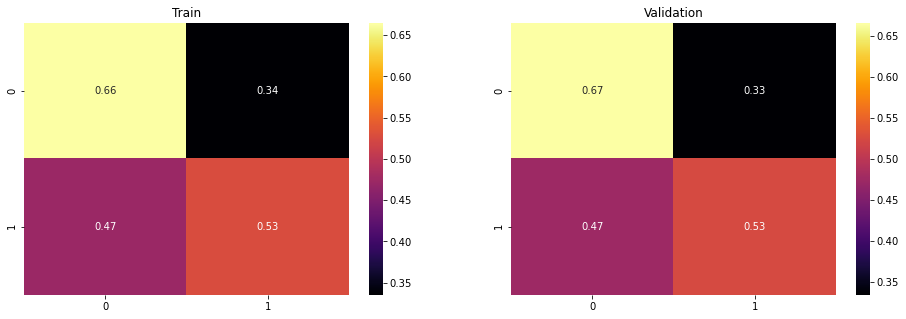

In [82]:
# plots of various scoring metrics
if(eda=='y'):
    get_scoring_plots(train_val, test_val, target_X, target_CV)

5) SVM

In [83]:
svm = SVC(max_iter=100, C=0.5, probability=True, class_weight='balanced', random_state=21)
svm.fit(train_X, target_X)

train_val = svm.predict_proba(train_X)[:,1]
test_val = svm.predict_proba(train_CV)[:,1]

g = gini_normalized(target_CV, svm.predict_proba(train_CV)[:,1])
print(g)
svm.fit(train_ohe, train_target)
ans_svm = svm.predict_proba(test_ohe)[:,1]

0.047302184177969525


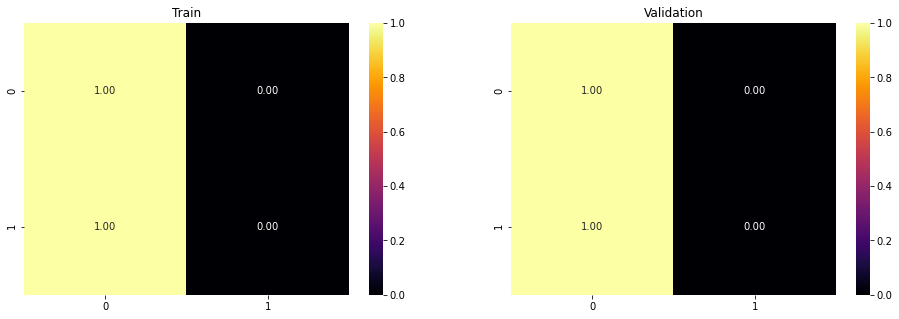

In [84]:
# plots of various scoring metrics
if(eda=='y'):
    get_scoring_plots(train_val, test_val, target_X, target_CV)

6) Naive Bayes

In [85]:
modelG = GaussianNB(var_smoothing =1e+6)
modelG.fit(train_X, target_X)
modelG.get_params(deep=True)

train_val = modelG.predict_proba(train_X)[:,1]
test_val = modelG.predict_proba(train_CV)[:,1]

scorerg = gini_normalized(target_CV,test_val)
#
'''modelNB = MultinomialNB(alpha=2.0,fit_prior=False)
modelNB.fit(train_X, target_X)
ansnb = modelNB.predict_proba(train_CV)
scorernb = gini_normalized(target_CV,ansnb[:,1])
#
modelCNB = ComplementNB(alpha=3,norm=False,fit_prior=False)
modelCNB.fit(train_X, target_X)
anscnb = modelCNB.predict_proba(train_CV)
scorercnb = gini_normalized(target_CV,anscnb[:,1])
#
modelbNB = BernoulliNB(alpha=5,binarize=0)
modelbNB.fit(train_X, target_X)
ansbnb = modelbNB.predict_proba(train_CV)
scorerbnb = gini_normalized(target_CV,ansbnb[:,1])
#
modelcaNB = CategoricalNB(alpha=5)
modelcaNB.fit(train_X, target_X)
har = modelcaNB.predict_proba(train_CV)
scorercanb = gini_normalized(target_CV,har[:,1])

'''
print("Gaussian Naive Bayes ",scorerg)
'''print("Multinomial Naive Bayes ",scorernb)
print("Complement Naive Bayes ",scorercnb)
print("Bernoulli Naive Bayes ",scorerbnb)
print("Categorical Naive Bayes ",scorercanb)'''

Gaussian Naive Bayes  0.21382477328567928


'print("Multinomial Naive Bayes ",scorernb)\nprint("Complement Naive Bayes ",scorercnb)\nprint("Bernoulli Naive Bayes ",scorerbnb)\nprint("Categorical Naive Bayes ",scorercanb)'

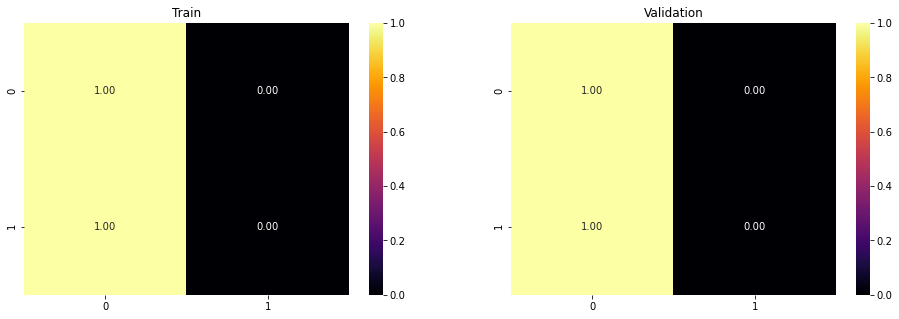

In [86]:
# plots of various scoring metrics
if(eda=='y'):
    get_scoring_plots(train_val, test_val, target_X, target_CV)

7) Decision Tree

In [87]:
#
# parameters for decision tree classifier
parameters = dict(
    criterion = ["gini"],
    splitter = ["best"],
    class_weight = ["balanced"],
    max_features = [23, 25, 27],
    max_depth = [11, 13, 15],
    min_samples_split = [1, 3, 5],
    min_samples_leaf = [1, 3, 5],
    max_leaf_nodes = [2000, 4000, 6000],
    min_impurity_split = [0.05, 0.1, 0.3]
)

In [88]:
#
dt = DecisionTreeClassifier()
dt_rscv = RandomizedSearchCV(estimator=dt, param_distributions=parameters, verbose=1, cv=5, return_train_score=True, n_jobs=-1)

dt_rscv.fit(train_ohe, train_target)
print('Best Score: ', dt_rscv.best_score_)
print('Best Params: ', dt_rscv.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


Best Score:  0.6646317047311721
Best Params:  {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 3, 'min_impurity_split': 0.3, 'max_leaf_nodes': 4000, 'max_features': 27, 'max_depth': 15, 'criterion': 'gini', 'class_weight': 'balanced'}


In [89]:
dsct = DecisionTreeClassifier(**dt_rscv.best_params_)
dsct.fit(train_ohe, train_target)

train_val = dsct.predict_proba(train_X)[:,1]
test_val = dsct.predict_proba(train_CV)[:,1]

ans_dsct = dsct.predict_proba(test_ohe)[:,1]

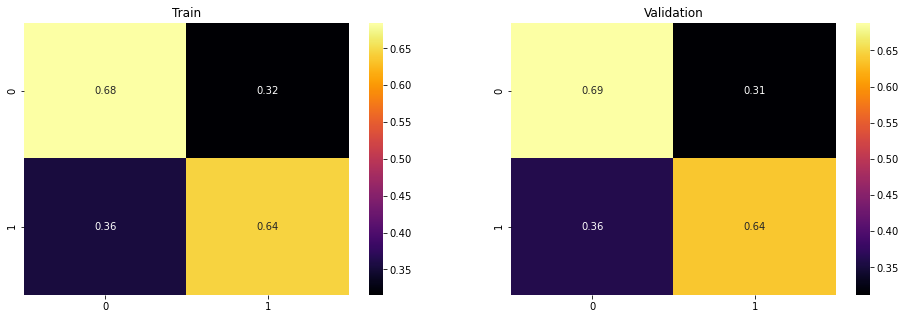

In [91]:
if(eda=='y'):
    get_scoring_plots(train_val, test_val, target_X, target_CV)

8) Adaboost

In [92]:
#
ada = AdaBoostClassifier(base_estimator = dsct, n_estimators=1000, learning_rate=0.01, algorithm="SAMME")
ada.fit(train_X, target_X)

train_val = ada.predict_proba(train_X)[:,1]
test_val = ada.predict_proba(train_CV)[:,1]

print(gini_normalized(target_CV, test_val))

0.665326966711948


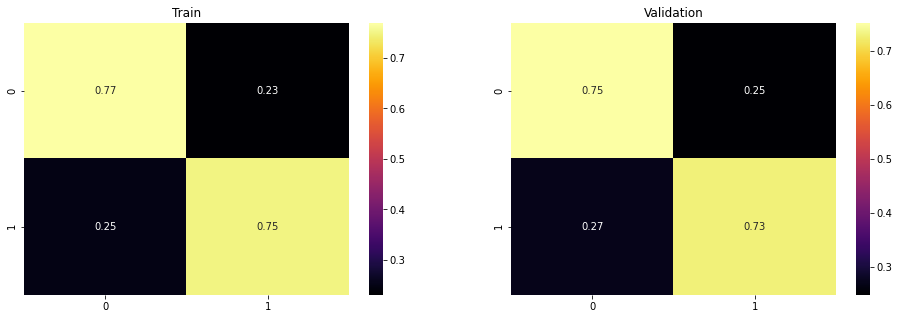

In [93]:
if(eda=='y'):
    get_scoring_plots(train_val, test_val, target_X, target_CV)

In [95]:
#
ada.fit(train_ohe, train_target)
ans_ada = ada.predict_proba(test_ohe)[:,1]

9) GradientBoostingClassifier

In [96]:
gbc_params = dict(
    learning_rate = [0.05,0.1],
    n_estimators = [150,200,250]
)
gbc = GradientBoostingClassifier()
gbc_rscv = RandomizedSearchCV(estimator=gbc, param_distributions=gbc_params, verbose=1, cv=2, return_train_score=True, n_jobs=-1)

gbc_rscv.fit(train_ohe, train_target)
print('Best Score: ', gbc_rscv.best_score_)
print('Best Params: ', gbc_rscv.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [98]:
gbc = GradientBoostingClassifier(n_estimators=250, learning_rate=0.1, verbose=True)
gbc.fit(train_X, target_X)

train_val = gbc.predict_proba(train_X)[:,1]
test_val = gbc.predict_proba(train_CV)[:,1]

print(gini_normalized(target_CV, test_val))

      Iter       Train Loss   Remaining Time 
         1           1.2685           15.66m
         2           1.2642           15.26m
         3           1.2605           15.10m
         4           1.2573           14.92m
         5           1.2547           14.79m
         6           1.2522           14.72m
         7           1.2500           14.62m
         8           1.2477           14.61m
         9           1.2459           14.68m
        10           1.2439           14.68m
        20           1.2325           14.14m
        30           1.2257           13.55m
        40           1.2212           12.96m
        50           1.2179           12.37m
        60           1.2156           11.71m
        70           1.2137           11.06m
        80           1.2121           10.42m
        90           1.2105            9.81m
       100           1.2091            9.22m
       200           1.1985            3.06m
0.3315182300380518


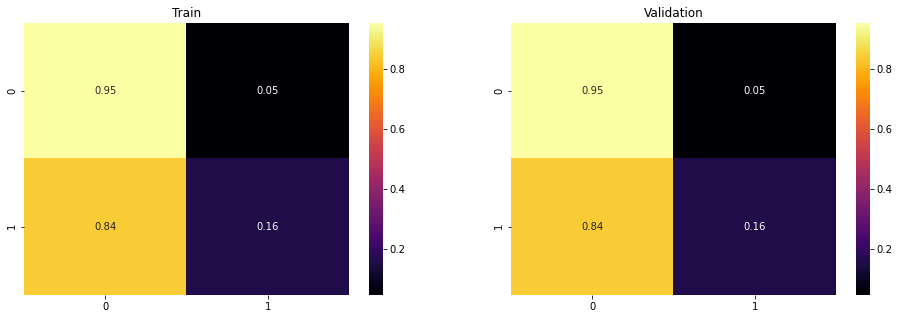

In [99]:
if(eda=='y'):
    get_scoring_plots(train_val, test_val, target_X, target_CV)

In [100]:
gbc.fit(train_ohe, train_target)
ans_gbc = gbc.predict_proba(test_ohe)[:,1]

      Iter       Train Loss   Remaining Time 
         1           1.2677           20.20m
         2           1.2634           20.05m
         3           1.2597           19.86m
         4           1.2566           19.77m
         5           1.2538           19.67m
         6           1.2514           19.53m
         7           1.2493           19.52m
         8           1.2470           19.52m
         9           1.2452           19.43m
        10           1.2435           19.31m
        20           1.2320           18.69m
        30           1.2253           17.84m
        40           1.2208           17.05m
        50           1.2176           16.21m
        60           1.2152           15.40m
        70           1.2131           14.60m
        80           1.2116           13.79m
        90           1.2099           12.96m
       100           1.2086           12.14m
       200           1.1983            4.03m


10) XGBoost

In [101]:
#
# grid search for xgboost
xgb_params = dict(
        n_estimators=[100, 150, 200],
        max_depth=[3, 5, 7],
        learning_rate=[0.05, 0.1],
        min_child_weight=[99, 100, 101],
        max_leaves=[5, 7, 9],
        reg_lamda=[0.5]
)

xg = xgb.XGBClassifier(n_jobs=-1, grow_policy="lossguide", sampling_method="gradient_based", update="prune")
xg_rscv = RandomizedSearchCV(estimator=xg, param_distributions=xgb_params, verbose=1, cv=3, return_train_score=True, n_jobs=-1)

xg_rscv.fit(train_ohe, train_target)
print('Best Score: ', xg_rscv.best_score_)
print('Best Params: ', xg_rscv.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [106]:
#
final_xgb_model_params = {
    "n_estimators":150,
    "learning_rate":0.1,
    "max_depth":5,
    "subsample":0.8,
    "min_child_weight":101,
    "n_jobs":-1
}

In [108]:
#
final_xgb_model = xgb.XGBClassifier(**final_xgb_model_params, grow_policy="lossguide", update="prune")
final_xgb_model.fit(train_X, target_X)

train_val = final_xgb_model.predict_proba(train_X)[:,1]
test_val = final_xgb_model.predict_proba(train_CV)[:,1]

print(gini_normalized(target_CV, test_val))

[09:18:28] WARNING: ../src/learner.cc:516: 
Parameters: { update } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.37549815903087713


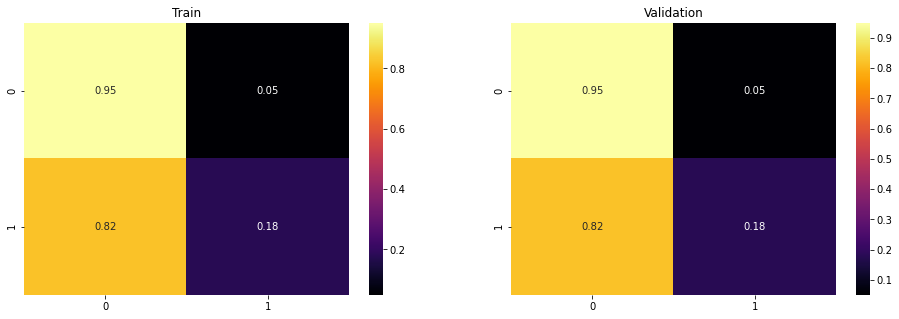

In [109]:
if(eda=='y'):
    get_scoring_plots(train_val, test_val, target_X, target_CV)

In [110]:
final_xgb_model.fit(train_ohe, train_target)
ans_xgb = final_xgb_model.predict_proba(test_ohe)[:,1]

[09:34:21] WARNING: ../src/learner.cc:516: 
Parameters: { update } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




11) Random Forest Classifier

In [113]:
#
# grid search for randomforestclassifier
rfc_params = dict(
        n_estimators=[300, 500, 700, 1000],
        max_depth=[3, 5, 9, 11],
)

rfc = RandomForestClassifier()
rfc_rscv = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_params, verbose=1, cv=2, return_train_score=True, n_jobs=-1)

rfc_rscv.fit(train_ohe, train_target)
print('Best Score: ', rfc_rscv.best_score_)
print('Best Params: ', rfc_rscv.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 39.8min finished


Best Score:  0.6974977631082664
Best Params:  {'n_estimators': 300, 'max_depth': 11}


In [114]:
#
rfc = RandomForestClassifier(**rfc_rscv.best_params_, criterion="gini", n_jobs=-1, verbose=1, oob_score=True)
rfc.fit(train_X, target_X)

train_val = rfc.predict_proba(train_X)[:,1]
test_val = rfc.predict_proba(train_CV)[:,1]

print(gini_normalized(target_CV, test_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s


0.4273135219215308


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.5s finished


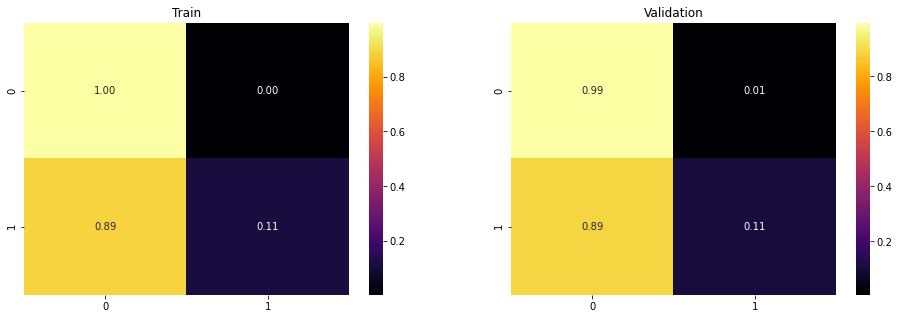

In [115]:
if(eda=='y'):
    get_scoring_plots(train_val, test_val, target_X, target_CV)

In [116]:
rfc.fit(train_ohe, train_target)
ans_rfc = rfc.predict_proba(test_ohe)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    3.7s finished


# Ensembling

In [156]:
#
test_ans = 0.2*ans_xgb + 0.8*ans_cat

In [157]:
submit = pd.DataFrame()
submit["id"] = test_id
submit["target"] = test_ans
submit.to_csv('xgb_cat_2_8.csv',index=False)
print("Saved to csv!")

Saved to csv!


**Stacking**

In [147]:
#
sclf = StackingClassifier(classifiers=[final_xgb_model], use_probas=True, meta_classifier=cat, use_features_in_secondary = True)
stacked_model = sclf.fit(train_X, target_X)

train_val = stacked_model.predict_proba(train_X)[:,1]
test_val = stacked_model.predict_proba(train_CV)[:,1]

print(gini_normalized(target_CV, test_val))

[12:09:25] WARNING: ../src/learner.cc:516: 
Parameters: { update } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0:	learn: 0.6862910	total: 155ms	remaining: 2m 34s
1:	learn: 0.6798240	total: 295ms	remaining: 2m 27s
2:	learn: 0.6737763	total: 426ms	remaining: 2m 21s
3:	learn: 0.6680875	total: 553ms	remaining: 2m 17s
4:	learn: 0.6628526	total: 682ms	remaining: 2m 15s
5:	learn: 0.6578903	total: 813ms	remaining: 2m 14s
6:	learn: 0.6532332	total: 941ms	remaining: 2m 13s
7:	learn: 0.6488572	total: 1.07s	remaining: 2m 12s
8:	learn: 0.6447290	total: 1.21s	remaining: 2m 13s
9:	learn: 0.6408942	total: 1.34s	remaining: 2m 13s
10:	learn: 0.6372689	total: 1.47s	remaining: 2m 12s
11:	learn: 0.6338471	total: 1.6s	remaining: 2m 11s
12:	learn: 0.6307119	total: 1.75s	remaining: 2m 13s
13:	learn

154:	learn: 0.5699573	total: 23.5s	remaining: 2m 8s
155:	learn: 0.5698799	total: 23.6s	remaining: 2m 7s
156:	learn: 0.5697792	total: 23.8s	remaining: 2m 7s
157:	learn: 0.5696778	total: 24s	remaining: 2m 7s
158:	learn: 0.5695760	total: 24.1s	remaining: 2m 7s
159:	learn: 0.5695007	total: 24.2s	remaining: 2m 7s
160:	learn: 0.5694155	total: 24.4s	remaining: 2m 7s
161:	learn: 0.5693081	total: 24.5s	remaining: 2m 6s
162:	learn: 0.5692252	total: 24.7s	remaining: 2m 6s
163:	learn: 0.5691390	total: 24.8s	remaining: 2m 6s
164:	learn: 0.5690344	total: 25s	remaining: 2m 6s
165:	learn: 0.5689547	total: 25.2s	remaining: 2m 6s
166:	learn: 0.5688809	total: 25.4s	remaining: 2m 6s
167:	learn: 0.5688040	total: 25.5s	remaining: 2m 6s
168:	learn: 0.5687219	total: 25.6s	remaining: 2m 6s
169:	learn: 0.5686333	total: 25.8s	remaining: 2m 5s
170:	learn: 0.5685541	total: 25.9s	remaining: 2m 5s
171:	learn: 0.5684794	total: 26.1s	remaining: 2m 5s
172:	learn: 0.5683935	total: 26.2s	remaining: 2m 5s
173:	learn: 0.56

312:	learn: 0.5572392	total: 46.6s	remaining: 1m 42s
313:	learn: 0.5571649	total: 46.7s	remaining: 1m 42s
314:	learn: 0.5571017	total: 46.9s	remaining: 1m 41s
315:	learn: 0.5570443	total: 47s	remaining: 1m 41s
316:	learn: 0.5569623	total: 47.2s	remaining: 1m 41s
317:	learn: 0.5568673	total: 47.3s	remaining: 1m 41s
318:	learn: 0.5567652	total: 47.5s	remaining: 1m 41s
319:	learn: 0.5566933	total: 47.6s	remaining: 1m 41s
320:	learn: 0.5566242	total: 47.8s	remaining: 1m 41s
321:	learn: 0.5565477	total: 47.9s	remaining: 1m 40s
322:	learn: 0.5564560	total: 48.1s	remaining: 1m 40s
323:	learn: 0.5563882	total: 48.2s	remaining: 1m 40s
324:	learn: 0.5563298	total: 48.3s	remaining: 1m 40s
325:	learn: 0.5562457	total: 48.5s	remaining: 1m 40s
326:	learn: 0.5561848	total: 48.6s	remaining: 1m 40s
327:	learn: 0.5561250	total: 48.8s	remaining: 1m 39s
328:	learn: 0.5560658	total: 48.9s	remaining: 1m 39s
329:	learn: 0.5559896	total: 49.1s	remaining: 1m 39s
330:	learn: 0.5559389	total: 49.2s	remaining: 1m

468:	learn: 0.5463517	total: 1m 9s	remaining: 1m 18s
469:	learn: 0.5463018	total: 1m 9s	remaining: 1m 18s
470:	learn: 0.5462557	total: 1m 9s	remaining: 1m 18s
471:	learn: 0.5461714	total: 1m 9s	remaining: 1m 17s
472:	learn: 0.5460899	total: 1m 9s	remaining: 1m 17s
473:	learn: 0.5460008	total: 1m 9s	remaining: 1m 17s
474:	learn: 0.5459137	total: 1m 10s	remaining: 1m 17s
475:	learn: 0.5458302	total: 1m 10s	remaining: 1m 17s
476:	learn: 0.5457550	total: 1m 10s	remaining: 1m 17s
477:	learn: 0.5456683	total: 1m 10s	remaining: 1m 17s
478:	learn: 0.5456034	total: 1m 10s	remaining: 1m 16s
479:	learn: 0.5455442	total: 1m 10s	remaining: 1m 16s
480:	learn: 0.5454584	total: 1m 10s	remaining: 1m 16s
481:	learn: 0.5453867	total: 1m 11s	remaining: 1m 16s
482:	learn: 0.5453279	total: 1m 11s	remaining: 1m 16s
483:	learn: 0.5452504	total: 1m 11s	remaining: 1m 16s
484:	learn: 0.5451526	total: 1m 11s	remaining: 1m 15s
485:	learn: 0.5451030	total: 1m 11s	remaining: 1m 15s
486:	learn: 0.5450282	total: 1m 11

624:	learn: 0.5356406	total: 1m 32s	remaining: 55.8s
625:	learn: 0.5355715	total: 1m 33s	remaining: 55.6s
626:	learn: 0.5354924	total: 1m 33s	remaining: 55.5s
627:	learn: 0.5354291	total: 1m 33s	remaining: 55.3s
628:	learn: 0.5353729	total: 1m 33s	remaining: 55.2s
629:	learn: 0.5353083	total: 1m 33s	remaining: 55s
630:	learn: 0.5352613	total: 1m 33s	remaining: 54.9s
631:	learn: 0.5352252	total: 1m 33s	remaining: 54.7s
632:	learn: 0.5351750	total: 1m 34s	remaining: 54.5s
633:	learn: 0.5351070	total: 1m 34s	remaining: 54.4s
634:	learn: 0.5350463	total: 1m 34s	remaining: 54.2s
635:	learn: 0.5349766	total: 1m 34s	remaining: 54.1s
636:	learn: 0.5349195	total: 1m 34s	remaining: 53.9s
637:	learn: 0.5348534	total: 1m 34s	remaining: 53.8s
638:	learn: 0.5347706	total: 1m 34s	remaining: 53.6s
639:	learn: 0.5347083	total: 1m 35s	remaining: 53.5s
640:	learn: 0.5346428	total: 1m 35s	remaining: 53.3s
641:	learn: 0.5345888	total: 1m 35s	remaining: 53.2s
642:	learn: 0.5345418	total: 1m 35s	remaining: 5

780:	learn: 0.5260755	total: 1m 55s	remaining: 32.3s
781:	learn: 0.5260115	total: 1m 55s	remaining: 32.1s
782:	learn: 0.5259634	total: 1m 55s	remaining: 32s
783:	learn: 0.5258913	total: 1m 55s	remaining: 31.8s
784:	learn: 0.5258390	total: 1m 55s	remaining: 31.7s
785:	learn: 0.5257762	total: 1m 55s	remaining: 31.5s
786:	learn: 0.5257347	total: 1m 55s	remaining: 31.4s
787:	learn: 0.5256705	total: 1m 55s	remaining: 31.2s
788:	learn: 0.5256037	total: 1m 56s	remaining: 31.1s
789:	learn: 0.5255324	total: 1m 56s	remaining: 30.9s
790:	learn: 0.5254685	total: 1m 56s	remaining: 30.8s
791:	learn: 0.5254060	total: 1m 56s	remaining: 30.6s
792:	learn: 0.5253270	total: 1m 56s	remaining: 30.5s
793:	learn: 0.5252548	total: 1m 56s	remaining: 30.3s
794:	learn: 0.5252021	total: 1m 56s	remaining: 30.2s
795:	learn: 0.5251134	total: 1m 57s	remaining: 30s
796:	learn: 0.5250479	total: 1m 57s	remaining: 29.9s
797:	learn: 0.5249800	total: 1m 57s	remaining: 29.7s
798:	learn: 0.5249327	total: 1m 57s	remaining: 29.

937:	learn: 0.5167128	total: 2m 17s	remaining: 9.12s
938:	learn: 0.5166762	total: 2m 18s	remaining: 8.97s
939:	learn: 0.5166197	total: 2m 18s	remaining: 8.82s
940:	learn: 0.5165678	total: 2m 18s	remaining: 8.68s
941:	learn: 0.5165181	total: 2m 18s	remaining: 8.53s
942:	learn: 0.5164608	total: 2m 18s	remaining: 8.38s
943:	learn: 0.5164070	total: 2m 18s	remaining: 8.23s
944:	learn: 0.5163357	total: 2m 18s	remaining: 8.09s
945:	learn: 0.5162666	total: 2m 19s	remaining: 7.94s
946:	learn: 0.5162112	total: 2m 19s	remaining: 7.79s
947:	learn: 0.5161492	total: 2m 19s	remaining: 7.64s
948:	learn: 0.5160587	total: 2m 19s	remaining: 7.5s
949:	learn: 0.5160162	total: 2m 19s	remaining: 7.35s
950:	learn: 0.5159674	total: 2m 19s	remaining: 7.2s
951:	learn: 0.5159044	total: 2m 19s	remaining: 7.06s
952:	learn: 0.5158410	total: 2m 20s	remaining: 6.91s
953:	learn: 0.5157951	total: 2m 20s	remaining: 6.77s
954:	learn: 0.5157338	total: 2m 20s	remaining: 6.62s
955:	learn: 0.5156821	total: 2m 20s	remaining: 6

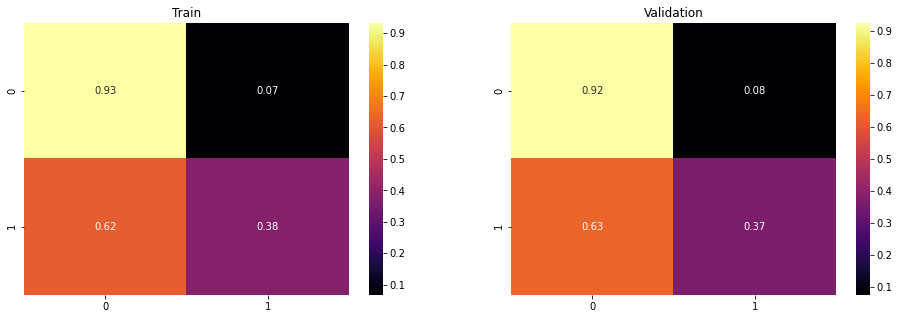

In [148]:
if(eda=='y'):
    get_scoring_plots(train_val, test_val, target_X, target_CV)

In [149]:
#
test_ans = stacked_model.predict_proba(test_ohe)[:,1]
submit = pd.DataFrame()
submit["id"] = test_id
submit["target"] = test_ans
submit.to_csv('stacked__xgb__cat.csv',index=False)
print("Saved to csv!")

Saved to csv!
